
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_19663/4029671479.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


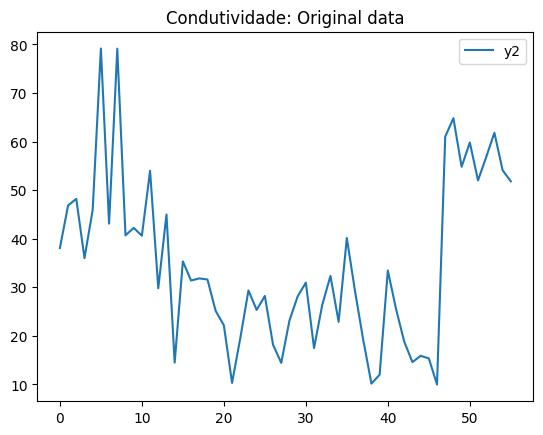

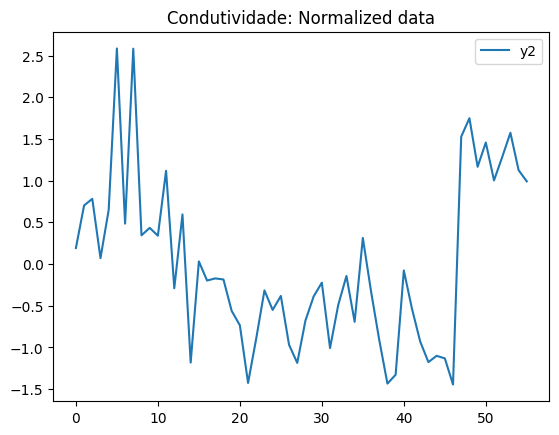

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.express as px

scaler = StandardScaler()

def getData(output, label):
    df_orig = pd.read_excel("../../../data.xlsx")
    df_orig.plot(y=[output], title=f"{label}: Original data")
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df.plot(y=[output], title=f"{label}: Normalized data")
    return (df)

def create_dataframe(output, label):
    df = getData(output, label)
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    return output, input

output, input = create_dataframe(output="y2", label="Condutividade")



In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-03-28 20:13:13.682136: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 20:13:13.741607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 20:13:13.741668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 20:13:13.743273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 20:13:13.752209: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 20:13:13.753195: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error


class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
 
 
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
          self.test_prediction = self.lm_model.predict(self.test_input)

          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.test_prediction.flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()

          r2 = r2_score(self.output, pred)
          r2_test = r2_score(self.test_output, test_pred)
          r2_val = r2_score(self.val_output, val_pred)
          r2_vt = r2_score(self.vt_output, vt_pred)

          mse = mean_squared_error(self.output, pred)
          mse_test = mean_squared_error(self.test_output, test_pred)
          mse_val = mean_squared_error(self.val_output, val_pred)
          mse_vt = mean_squared_error(self.vt_output, vt_pred)

          metrics = {
                          'r2': r2,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt
                          }

          return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._train, trainer._vt, trainer._val, trainer._test), f)


  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinacao1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.087118016000204
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.5201758319999499
Stopped at epoch:  8
1/1 [==============================] - 0s 27ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.3921777610003119
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.4995298190001449
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.4980628519997481
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.4295414149996759
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.803142,0.620511,0.775238,0.723787,0.196858,0.301368,0.351495,0.324957
model_4_4_7,0.805046,0.136722,0.722889,0.518152,0.194954,0.685565,0.433363,0.566882
model_4_4_6,0.809781,0.211669,0.724919,0.546206,0.190219,0.626047,0.430188,0.533878
model_4_4_1,0.809877,0.553757,0.760615,0.690785,0.190123,0.354380,0.374364,0.363784
model_4_4_5,0.813396,0.285423,0.728084,0.574542,0.186604,0.567476,0.425238,0.500540
model_4_4_2,0.813945,0.488583,0.748896,0.660163,0.186055,0.406137,0.392690,0.399810
model_4_4_4,0.815486,0.356100,0.732907,0.602817,0.184514,0.511348,0.417695,0.467276
model_4_4_3,0.815741,0.423388,0.739756,0.631147,0.184259,0.457912,0.406985,0.433946


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.36830032999978357
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.3609897390001606
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.3384557859999404
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.3917217879998134
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.322221288000037
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.3388286919998791
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.316065469000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_12,0.802294,0.689867,0.023515,0.486056,0.197706,0.484564,0.761438,0.614857
model_4_5_11,0.812314,0.694958,0.125094,0.520733,0.187686,0.476610,0.682229,0.573372
model_4_5_0,0.814185,0.817244,0.978424,0.867022,0.185815,0.285545,0.016824,0.159088
model_4_5_10,0.822367,0.700915,0.230383,0.557147,0.177633,0.467302,0.600128,0.529808
model_4_5_9,0.832131,0.707864,0.337479,0.594801,0.167869,0.456445,0.516616,0.484761
model_4_5_1,0.834514,0.805184,0.952831,0.850833,0.165486,0.304389,0.036781,0.178456
model_4_5_8,0.841211,0.715977,0.444011,0.633086,0.158789,0.443769,0.433545,0.438958
model_4_5_2,0.848213,0.791346,0.916718,0.830189,0.151787,0.326009,0.064941,0.203153
model_4_5_7,0.849127,0.725434,0.547190,0.671273,0.150873,0.428992,0.353090,0.393273
model_4_5_6,0.855305,0.736360,0.643992,0.708519,0.144695,0.411921,0.277606,0.348714


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.5500619150002422
Stopped at epoch:  10
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.38712418700015405
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.36923143500007427
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.33873869199987894
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.4362001610002153
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.27611598100020274
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.3305012

2024-03-28 20:22:08.838568: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3825811470001099
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 14 ++++++++++++++++++
Elapsed time:  0.3516691609997906
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 15 ++++++++++++++++++
Elapsed time:  0.3592505359997631
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_6] | 16 ++++++++++++++++++
Elapsed time:  0.30636381800013623
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_6] | 17 ++++++++++++++++++
Elapsed time:  0.3129137310002079
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 18 ++++++++++++++++++
Elapsed time:  0.3418119640000441
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [4_6] | 19 ++++++++++++++++++
Elapsed time:  0.3360550869997496
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/ste

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.851419,0.611010,0.813514,0.802217,0.148581,0.176857,0.364997,0.265394
model_4_6_1,0.859203,0.550011,0.810774,0.789395,0.140797,0.204591,0.370359,0.282600
model_4_6_2,0.864847,0.492564,0.808435,0.777485,0.135153,0.230710,0.374938,0.298582
model_4_6_3,0.868914,0.439068,0.806634,0.766652,0.131086,0.255032,0.378462,0.313117
model_4_6_24,0.869728,-0.038904,0.807134,0.681257,0.130272,0.472346,0.377484,0.427705
model_4_6_23,0.870102,-0.031837,0.806991,0.682426,0.129898,0.469133,0.377765,0.426136
model_4_6_22,0.870506,-0.024002,0.806833,0.683723,0.129494,0.465570,0.378072,0.424395
model_4_6_21,0.870938,-0.015318,0.806661,0.685163,0.129062,0.461622,0.378410,0.422463
model_4_6_20,0.871398,-0.005692,0.806473,0.686761,0.128602,0.457246,0.378777,0.420319
model_4_6_4,0.871798,0.389617,0.805352,0.756902,0.128202,0.277515,0.380972,0.326201


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.278788534999876
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.2297526470001685
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.31399025799964875
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.3420022569998764
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.42402121200029796
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.28499084900022353
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.3002720290

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.891825,0.984911,0.901428,0.951366,0.108175,0.019502,0.103532,0.059045
model_4_7_1,0.908209,0.981197,0.899112,0.948330,0.091791,0.024302,0.105965,0.062732
model_4_7_2,0.920382,0.976303,0.893486,0.943282,0.079618,0.030628,0.111873,0.068861
model_4_7_3,0.929399,0.970896,0.885896,0.937144,0.070601,0.037616,0.119846,0.076312
model_4_7_4,0.936023,0.965349,0.877179,0.930469,0.063977,0.044786,0.129001,0.084417
model_4_7_5,0.940818,0.959875,0.867879,0.923598,0.059182,0.051860,0.138769,0.092758
model_4_7_24,0.941916,0.904109,0.749410,0.843939,0.058084,0.123937,0.263200,0.189472
model_4_7_23,0.942445,0.905291,0.752188,0.845736,0.057555,0.122408,0.260281,0.187290
model_4_7_22,0.943011,0.906595,0.755244,0.847715,0.056989,0.120724,0.257072,0.184888
model_4_7_21,0.943610,0.908029,0.758600,0.849890,0.056390,0.118870,0.253547,0.182247


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.35515321000002587
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.3443832050002129
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.40932169699999577
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.3850650899998982
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.3569387590000588
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.3775119229999291
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.3310823159

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_24,0.909223,0.573704,0.940389,0.768632,0.090777,0.486215,0.086797,0.298253
model_4_8_23,0.910637,0.581143,0.940899,0.772387,0.089363,0.477729,0.086055,0.293412
model_4_8_22,0.912187,0.589326,0.941466,0.776522,0.087813,0.468397,0.085229,0.288082
model_4_8_21,0.913881,0.598313,0.942099,0.781068,0.086119,0.458146,0.084308,0.282222
model_4_8_20,0.915731,0.608170,0.942804,0.786060,0.084269,0.446904,0.083281,0.275787
model_4_8_19,0.917743,0.618957,0.943591,0.791531,0.082257,0.434600,0.082136,0.268734
model_4_8_18,0.919927,0.630736,0.944469,0.797515,0.080073,0.421166,0.080856,0.261020
model_4_8_17,0.922287,0.643563,0.945451,0.804045,0.077713,0.406536,0.079427,0.252602
model_4_8_16,0.924826,0.657486,0.946549,0.811151,0.075175,0.390656,0.077828,0.243443
model_4_8_15,0.927543,0.672542,0.947778,0.818856,0.072457,0.373484,0.076038,0.233509


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.8075315500000215
Stopped at epoch:  15
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.32746841900006984
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.35167215699993903
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.3994344990001082
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.3598195980002856
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.3334324390002621
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.363498606

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_24,0.928247,0.248501,0.914240,0.674011,0.071753,0.385085,0.068819,0.236254
model_4_9_23,0.928389,0.249770,0.914630,0.674689,0.071611,0.384434,0.068506,0.235762
model_4_9_22,0.928545,0.251177,0.915063,0.675441,0.071455,0.383713,0.068159,0.235217
model_4_9_21,0.928717,0.252736,0.915542,0.676274,0.071283,0.382914,0.067774,0.234613
model_4_9_20,0.928905,0.254465,0.916072,0.677198,0.071095,0.382028,0.067349,0.233944
model_4_9_19,0.929113,0.256380,0.916659,0.678221,0.070887,0.381047,0.066877,0.233202
model_4_9_18,0.929340,0.258502,0.917309,0.679354,0.070660,0.379960,0.066356,0.232382
model_4_9_17,0.929589,0.260850,0.918028,0.680607,0.070411,0.378757,0.065779,0.231473
model_4_9_16,0.929860,0.263448,0.918821,0.681993,0.070140,0.377425,0.065142,0.230469
model_4_9_15,0.930156,0.266323,0.919698,0.683526,0.069844,0.375952,0.064439,0.229358


DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.9864743129996896
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.4456075080001938
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.443041785999867
Stopped at epoch:  8
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.394263341000169
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.30343962799997826
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.3172874470001261
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_3,0.801603,0.099521,0.575220,0.431817,0.198397,0.461686,0.566229,0.510883
model_5_6_0,0.803448,0.324801,0.687420,0.578100,0.196552,0.346183,0.416668,0.379352
model_5_6_2,0.804093,0.169123,0.611369,0.478047,0.195907,0.426001,0.518043,0.469315
model_5_6_1,0.804929,0.244209,0.648942,0.526927,0.195071,0.387503,0.467958,0.425364


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.3670527250001214
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.24977985799978342
Stopped at epoch:  6
1/1 [==============================] - 0s 56ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.4083829040000637
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.32521049800016044
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.3956087960000332
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.3244482079999216
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.3042892809

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_11,0.803270,0.614498,0.419917,0.518267,0.196730,0.284483,0.996543,0.619570
model_5_7_0,0.805781,0.862009,0.637159,0.730007,0.194219,0.101831,0.623336,0.347245
model_5_7_10,0.807348,0.635130,0.434839,0.533914,0.192652,0.269257,0.970908,0.599446
model_5_7_9,0.811395,0.657020,0.450979,0.550708,0.188606,0.253104,0.943181,0.577846
model_5_7_8,0.815292,0.680070,0.468359,0.568635,0.184708,0.236094,0.913324,0.554790
model_5_7_1,0.815807,0.845972,0.616354,0.712058,0.184193,0.113666,0.659078,0.370330
model_5_7_7,0.818879,0.704115,0.486972,0.587639,0.181121,0.218350,0.881347,0.530349
model_5_7_2,0.821770,0.826021,0.594289,0.692127,0.178230,0.128389,0.696984,0.395963
model_5_7_6,0.821939,0.728903,0.506770,0.607613,0.178061,0.200057,0.847335,0.504659
model_5_7_5,0.824190,0.754072,0.527647,0.628382,0.175810,0.181483,0.811470,0.477948


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.2952344959999209
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.26606607199983046
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.3536381139997502
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.26104648599994107
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.31600344200023756
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.3902690419999999
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.346254745

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_8,0.804032,0.379195,0.210932,0.304948,0.195968,0.378040,0.720864,0.539369
model_5_8_0,0.805926,0.986983,0.867055,0.920940,0.194074,0.007927,0.121454,0.061351
model_5_8_7,0.817954,0.470260,0.307443,0.396247,0.182046,0.322585,0.632694,0.468519
model_5_8_1,0.829927,0.951336,0.820742,0.880474,0.170073,0.029634,0.163764,0.092754
model_5_8_6,0.830389,0.563117,0.404940,0.488837,0.169611,0.266041,0.543625,0.396668
model_5_8_5,0.840421,0.655455,0.501409,0.580642,0.159579,0.209811,0.455494,0.325427
model_5_8_2,0.843398,0.896257,0.757428,0.822516,0.156602,0.063174,0.221605,0.137730
model_5_8_4,0.846902,0.744242,0.594342,0.669013,0.153098,0.155744,0.370594,0.256850
model_5_8_3,0.848437,0.825844,0.680785,0.750803,0.151563,0.106052,0.291623,0.193380


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.8922371150001709
Stopped at epoch:  15
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.39233698899988667
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.4860055150002154
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.38588597899979504
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.3656118579997383
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.3476081379999414
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.331820972

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_24,0.800572,0.220726,0.579132,0.351550,0.199428,0.946278,0.330083,0.656304
model_5_9_23,0.801274,0.223974,0.580145,0.353983,0.198726,0.942333,0.329288,0.653842
model_5_9_22,0.802045,0.227576,0.581249,0.356673,0.197955,0.937960,0.328422,0.651119
model_5_9_21,0.802889,0.231566,0.582451,0.359646,0.197111,0.933115,0.327480,0.648110
model_5_9_20,0.803812,0.235986,0.583752,0.362927,0.196188,0.927748,0.326460,0.644789
model_5_9_19,0.804820,0.240881,0.585157,0.366549,0.195180,0.921804,0.325357,0.641123
model_5_9_18,0.805917,0.246298,0.586671,0.370542,0.194083,0.915225,0.324170,0.637081
model_5_9_17,0.807108,0.252293,0.588292,0.374941,0.192892,0.907945,0.322899,0.632629
model_5_9_16,0.808398,0.258923,0.590021,0.379783,0.191602,0.899894,0.321543,0.627729
model_5_9_15,0.809789,0.266253,0.591852,0.385106,0.190211,0.890994,0.320107,0.622342


DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.9283316340001875
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.30063053999992917
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.3189050999999381
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.3327625900001294
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.3077634279998165
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.3478685850000147
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms

2024-03-28 20:26:52.034803: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.3430513440002869
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.3779523060002248
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_3] | 8 ++++++++++++++++++
Elapsed time:  0.37111762600034126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_3] | 9 ++++++++++++++++++
Elapsed time:  0.44964432699998724
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_3] | 10 ++++++++++++++++++
Elapsed time:  0.2924432969998634
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_3] | 11 ++++++++++++++++++
Elapsed time:  0.33443417700027567
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_3] | 12 ++++++++++++++++++
Elapsed time:

2024-03-28 20:27:15.966097: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3982644679999794
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 17 ++++++++++++++++++
Elapsed time:  0.3346365119996335
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_4] | 18 ++++++++++++++++++
Elapsed time:  0.33536894899998515
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_4] | 19 ++++++++++++++++++
Elapsed time:  0.3484292110001661
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_4] | 20 ++++++++++++++++++
Elapsed time:  0.28697988900012206
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_4] | 21 ++++++++++++++++++
Elapsed time:  0.31259615999988455
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_4] | 22 ++++++++++++++++++
Elapsed time:  0.351157929999772
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/st

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.876001,0.878912,0.594052,0.860694,0.123999,0.234165,0.110585,0.176010
model_6_7_24,0.883362,0.720772,0.244213,0.697058,0.116638,0.539984,0.205885,0.382761
model_6_7_23,0.884076,0.722817,0.248904,0.699191,0.115924,0.536030,0.204607,0.380066
model_6_7_1,0.884325,0.865785,0.565435,0.847154,0.115675,0.259550,0.118380,0.193117
model_6_7_22,0.884851,0.725074,0.254073,0.701544,0.115149,0.531665,0.203199,0.377093
model_6_7_21,0.885687,0.727562,0.259765,0.704138,0.114313,0.526852,0.201648,0.373815
model_6_7_20,0.886588,0.730305,0.266024,0.706996,0.113412,0.521548,0.199943,0.370205
model_6_7_19,0.887552,0.733325,0.272901,0.710140,0.112448,0.515709,0.198070,0.366232
model_6_7_18,0.888580,0.736645,0.280451,0.713597,0.111420,0.509287,0.196013,0.361864
model_6_7_17,0.889667,0.740293,0.288721,0.717392,0.110333,0.502233,0.193761,0.357069


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.30326125400006276
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.38857765600005223
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.33598633099973085
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.34205549700027404
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.289362789000279
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.3506543580001562
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.334966749

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.903969,0.970778,0.992759,0.984315,0.096031,0.026999,0.006199,0.017211
model_6_8_1,0.919244,0.962518,0.992873,0.980675,0.080756,0.034630,0.006101,0.021205
model_6_8_24,0.920232,0.527634,0.926343,0.762383,0.079768,0.436426,0.063060,0.260725
model_6_8_23,0.921787,0.537898,0.927781,0.767486,0.078213,0.426943,0.061829,0.255125
model_6_8_22,0.923473,0.549143,0.929374,0.773084,0.076527,0.416554,0.060466,0.248983
model_6_8_21,0.925295,0.561442,0.931137,0.779214,0.074705,0.405190,0.058957,0.242257
model_6_8_20,0.927255,0.574866,0.933087,0.785915,0.072745,0.392788,0.057287,0.234905
model_6_8_19,0.929355,0.589485,0.935244,0.793223,0.070645,0.379281,0.055440,0.226885
model_6_8_2,0.931260,0.951718,0.993000,0.975906,0.068740,0.044608,0.005993,0.026437
model_6_8_18,0.931590,0.605363,0.937626,0.801176,0.068410,0.364612,0.053401,0.218160


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.3781733079999867
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.38572711300002993
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.3797660000000178
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.3395565890000398
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.3246760530000756
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.31156485600013184
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.4515282410

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.934929,0.989198,0.973366,0.985470,0.065071,0.015029,0.012914,0.014034
model_6_9_1,0.945985,0.987046,0.972691,0.983670,0.054015,0.018023,0.013242,0.015773
model_6_9_2,0.954171,0.982644,0.969817,0.979634,0.045829,0.024147,0.014636,0.019671
model_6_9_24,0.957968,0.861181,0.846918,0.857975,0.042032,0.193135,0.074228,0.137179
model_6_9_23,0.958597,0.863541,0.849681,0.860428,0.041403,0.189851,0.072888,0.134810
model_6_9_22,0.959275,0.866140,0.852709,0.863125,0.040725,0.186235,0.071420,0.132205
model_6_9_21,0.960005,0.868998,0.856020,0.866087,0.039995,0.182259,0.069814,0.129344
model_6_9_3,0.960101,0.976681,0.965261,0.974010,0.039899,0.032443,0.016845,0.025103
model_6_9_20,0.960786,0.872137,0.859635,0.869334,0.039214,0.177892,0.068061,0.126207
model_6_9_19,0.961617,0.875579,0.863574,0.872889,0.038383,0.173104,0.066151,0.122773


DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  1.00684217800017
Stopped at epoch:  12
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.3007510639999964
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.3700626959998772
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.35167124700001295
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.37469635599973117
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.31976769000038985
Stopped at epoch:  6
1/1 [==============================] - 0s 23

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_10,0.805364,0.041540,-0.270984,-0.054131,0.194636,0.546465,0.647381,0.593955
model_7_3_0,0.809982,0.520056,0.580086,0.564260,0.190018,0.273640,0.213885,0.245520
model_7_3_9,0.811004,0.083628,-0.200768,-0.001714,0.188996,0.522468,0.611617,0.564420
model_7_3_8,0.816479,0.128280,-0.125487,0.054231,0.183521,0.497010,0.573272,0.532898
model_7_3_7,0.821604,0.175446,-0.045191,0.113656,0.178396,0.470118,0.532373,0.499414
model_7_3_1,0.822850,0.482629,0.503233,0.511517,0.177150,0.294978,0.253030,0.275238
model_7_3_6,0.826142,0.225043,0.039981,0.176457,0.173858,0.441841,0.488990,0.464029
model_7_3_2,0.829765,0.436163,0.414157,0.448731,0.170235,0.321471,0.298401,0.310615
model_7_3_5,0.829782,0.276876,0.129740,0.242408,0.170218,0.412288,0.443271,0.426868
model_7_3_4,0.832087,0.330397,0.223370,0.310911,0.167913,0.381773,0.395580,0.388270


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.5020210830002725
Stopped at epoch:  9
1/1 [==============================] - 0s 39ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.2855506639998566
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.3630680860001121
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.3709090639999886
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.35687980500006233
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.41088583300006576
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.3320115500

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_5,0.807064,0.721681,0.125683,0.550451,0.192936,0.463290,0.673574,0.562247
model_7_4_4,0.815645,0.751840,0.177180,0.586629,0.184355,0.413088,0.633900,0.516999
model_7_4_3,0.821684,0.782194,0.216121,0.619305,0.178316,0.362560,0.603900,0.476132
model_7_4_0,0.824137,0.882977,0.266227,0.704842,0.175863,0.194797,0.565299,0.369151
model_7_4_2,0.825239,0.813953,0.242986,0.649470,0.174761,0.309694,0.583204,0.438405
model_7_4_1,0.826216,0.847738,0.259130,0.677955,0.173784,0.253456,0.570766,0.402779


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.5273628559998542
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.29111055900011706
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.3326060280001002
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.3134560930002408
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.33306874000027165
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.3530764040001486
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.2697891949

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.815286,0.420643,0.909867,0.590245,0.184714,0.570125,0.048150,0.324490
model_7_5_21,0.822043,0.072432,0.603525,0.263919,0.177957,0.912788,0.211801,0.582912
model_7_5_20,0.823198,0.077372,0.611506,0.269703,0.176802,0.907926,0.207537,0.578331
model_7_5_19,0.824448,0.082895,0.620255,0.276113,0.175552,0.902492,0.202863,0.573255
model_7_5_18,0.825797,0.089072,0.629828,0.283216,0.174203,0.896413,0.197749,0.567630
model_7_5_1,0.826793,0.394808,0.897036,0.569176,0.173207,0.595549,0.055004,0.341175
model_7_5_17,0.827244,0.095988,0.640281,0.291084,0.172756,0.889608,0.192165,0.561399
model_7_5_16,0.828789,0.103734,0.651666,0.299794,0.171211,0.881984,0.186083,0.554502
model_7_5_15,0.830428,0.112420,0.664026,0.309432,0.169572,0.873437,0.179481,0.546869
model_7_5_14,0.832151,0.122162,0.677397,0.320086,0.167849,0.863850,0.172338,0.538432


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.469583873999909
Stopped at epoch:  9
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.3955730309999126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.3346420739999303
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.38235439400023097
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.3393229030002658
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.37644331299998157
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.33929097500

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.878542,0.565681,0.887691,0.698864,0.121458,0.483728,0.042239,0.275968
model_7_6_1,0.885502,0.565003,0.886477,0.698193,0.114498,0.484483,0.042696,0.276583
model_7_6_2,0.890690,0.563160,0.881378,0.696022,0.109310,0.486536,0.044613,0.278573
model_7_6_3,0.894483,0.560518,0.873406,0.692783,0.105517,0.489479,0.047611,0.281541
model_7_6_24,0.894742,0.508636,0.682391,0.622512,0.105258,0.547263,0.119451,0.345940
model_7_6_23,0.895100,0.509679,0.686627,0.624001,0.104900,0.546101,0.117858,0.344575
model_7_6_22,0.895486,0.510828,0.691278,0.625638,0.104514,0.544821,0.116109,0.343074
model_7_6_21,0.895900,0.512092,0.696375,0.627436,0.104100,0.543413,0.114192,0.341427
model_7_6_20,0.896342,0.513481,0.701953,0.629407,0.103658,0.541866,0.112094,0.339620
model_7_6_19,0.896811,0.515006,0.708048,0.631565,0.103189,0.540168,0.109802,0.337643


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.34362160799992125
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.2749822590003532
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.3959735789999286
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.39016733099970224
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.30865422800025044
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.30455086699976164
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.34354509

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.908501,0.707914,0.992254,0.850638,0.091499,0.198937,0.005784,0.108042
model_7_7_1,0.918438,0.706016,0.981275,0.844359,0.081562,0.200230,0.013981,0.112584
model_7_7_2,0.925523,0.701134,0.967228,0.835102,0.074477,0.203555,0.024470,0.119280
model_7_7_24,0.926570,0.561965,0.764509,0.667258,0.073430,0.298342,0.175833,0.240691
model_7_7_23,0.927101,0.564565,0.767621,0.670066,0.072899,0.296571,0.173509,0.238659
model_7_7_22,0.927676,0.567432,0.771064,0.673168,0.072324,0.294618,0.170938,0.236416
model_7_7_21,0.928298,0.570591,0.774872,0.676592,0.071702,0.292467,0.168095,0.233939
model_7_7_20,0.928967,0.574067,0.779079,0.680369,0.071033,0.290099,0.164953,0.231207
model_7_7_19,0.929682,0.577887,0.783727,0.684530,0.070318,0.287498,0.161483,0.228197
model_7_7_18,0.930442,0.582077,0.788856,0.689110,0.069558,0.284644,0.157654,0.224884


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.3517698579998978
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.3210009499998705
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.36197653700037336
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.44912329499993575
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.3805335980000564
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.35578160699969885
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.367683759

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.935825,0.913764,0.985009,0.948605,0.064175,0.114813,0.013485,0.067129
model_7_8_1,0.942793,0.908241,0.982703,0.944877,0.057207,0.122167,0.015559,0.071998
model_7_8_2,0.947993,0.902423,0.979926,0.940838,0.052007,0.129913,0.018057,0.077275
model_7_8_3,0.951828,0.896576,0.976849,0.936685,0.048172,0.137697,0.020824,0.082698
model_7_8_4,0.954612,0.890872,0.973609,0.932557,0.045388,0.145292,0.023739,0.088091
model_7_8_24,0.955846,0.835358,0.932664,0.889329,0.044154,0.219203,0.060570,0.144552
model_7_8_23,0.956092,0.836311,0.933493,0.890112,0.043908,0.217934,0.059824,0.143529
model_7_8_22,0.956357,0.837368,0.934407,0.890979,0.043643,0.216527,0.059002,0.142397
model_7_8_5,0.956590,0.885415,0.970312,0.928543,0.043410,0.152557,0.026705,0.093332
model_7_8_21,0.956639,0.838539,0.935414,0.891937,0.043361,0.214968,0.058096,0.141146


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.4198921510001128
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.34713704899968434
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.3392856999998912
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.3365948069999831
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.3024839250001605
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.43876490000002377
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.3783944510

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.963968,0.985109,0.998871,0.992942,0.036032,0.012917,0.001437,0.007515
model_7_9_1,0.970317,0.985314,0.998339,0.992732,0.029683,0.012739,0.002113,0.007738
model_7_9_2,0.975247,0.984727,0.997329,0.991911,0.024753,0.013249,0.003398,0.008613
model_7_9_3,0.979042,0.983540,0.995977,0.990639,0.020958,0.014278,0.005118,0.009967
model_7_9_4,0.981935,0.981917,0.994391,0.989047,0.018065,0.015685,0.007136,0.011662
model_7_9_5,0.984110,0.979991,0.992658,0.987241,0.015890,0.017356,0.009342,0.013585
model_7_9_6,0.985720,0.977870,0.990844,0.985306,0.014280,0.019196,0.011650,0.015645
model_7_9_7,0.986884,0.975637,0.989002,0.983308,0.013116,0.021133,0.013994,0.017773
model_7_9_24,0.986892,0.948550,0.968526,0.960110,0.013108,0.044629,0.040046,0.042473
model_7_9_23,0.987061,0.949360,0.969115,0.960790,0.012939,0.043927,0.039297,0.041748


DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.8063007280002239
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.325077181999859
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.3502383730001384
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.3033047760000045
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.30759093500000745
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.284033824999824
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/s

2024-03-28 20:31:47.124366: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3714702209999814
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Elapsed time:  0.3672188020000249
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_0] | 9 ++++++++++++++++++
Elapsed time:  0.3466463139998268
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_0] | 10 ++++++++++++++++++
Elapsed time:  0.36925486200016167
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 11 ++++++++++++++++++
Elapsed time:  0.38598265700011325
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 12 ++++++++++++++++++
Elapsed time:  0.36339019500019276
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [8_0] | 13 ++++++++++++++++++
Elapsed time:  0.42725486000017554
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/st

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_11,0.802130,-0.024230,-0.218345,-0.044226,0.197870,0.948110,0.242163,0.615900
model_8_4_0,0.803758,0.512464,0.543393,0.522504,0.196242,0.451302,0.090757,0.281634
model_8_4_10,0.806607,0.012961,-0.165533,-0.004950,0.193393,0.913683,0.231666,0.592734
model_8_4_9,0.811035,0.052972,-0.108131,0.037399,0.188965,0.876646,0.220256,0.567756
model_8_4_1,0.814906,0.458960,0.473432,0.466954,0.185094,0.500831,0.104663,0.314399
model_8_4_8,0.815278,0.095832,-0.046129,0.082842,0.184722,0.836971,0.207932,0.540953
model_8_4_7,0.819153,0.141504,0.020331,0.131330,0.180847,0.794693,0.194723,0.512354
model_8_4_2,0.821610,0.403756,0.397987,0.409121,0.178390,0.551932,0.119658,0.348509
model_8_4_6,0.822419,0.189877,0.090911,0.182715,0.177581,0.749915,0.180694,0.482046
model_8_4_5,0.824764,0.240736,0.165034,0.236728,0.175236,0.702836,0.165961,0.450189


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.35979143399981695
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.30594976900010806
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.23891632999993817
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.37666334300001836
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.4343857570002001
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.6022134139998343
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.29879548

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.805398,0.903535,0.878383,0.906986,0.194602,0.067968,0.084263,0.075636
model_8_5_1,0.837552,0.896003,0.880778,0.904492,0.162448,0.073275,0.082603,0.077664
model_8_5_2,0.862443,0.882628,0.880034,0.898058,0.137557,0.082698,0.083119,0.082896
model_8_5_3,0.881452,0.864318,0.876716,0.888328,0.118548,0.095599,0.085418,0.090808
model_8_5_4,0.895733,0.842133,0.871369,0.876008,0.104267,0.111230,0.089122,0.100826
model_8_5_5,0.906248,0.817187,0.864501,0.861811,0.093752,0.128807,0.093881,0.112371
model_8_5_24,0.912438,0.465125,0.738224,0.649682,0.087562,0.376863,0.181372,0.284867
model_8_5_23,0.913416,0.473148,0.741503,0.654677,0.086584,0.371210,0.179100,0.280805
model_8_5_6,0.913792,0.790533,0.856565,0.846402,0.086208,0.147587,0.099379,0.124901
model_8_5_22,0.914462,0.482010,0.745104,0.660186,0.085538,0.364966,0.176605,0.276326


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.5020735799998874
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.3500011619998986
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.34475618400028907
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.37234017199989466
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.37837703600007444
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.3279816130002473
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.338761754

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.954392,0.961056,0.964454,0.965792,0.045608,0.051282,0.019861,0.036496
model_8_6_1,0.959422,0.958738,0.951613,0.961113,0.040578,0.054336,0.027036,0.041489
model_8_6_24,0.962445,0.927047,0.725703,0.884729,0.037555,0.096066,0.153263,0.122982
model_8_6_23,0.962794,0.927515,0.729492,0.885968,0.037206,0.095451,0.151145,0.121660
model_8_6_2,0.963114,0.956370,0.937695,0.956135,0.036886,0.057454,0.034812,0.046799
model_8_6_22,0.963172,0.928030,0.733663,0.887333,0.036828,0.094772,0.148815,0.120204
model_8_6_21,0.963580,0.928599,0.738250,0.888835,0.036420,0.094023,0.146252,0.118601
model_8_6_20,0.964017,0.929226,0.743287,0.890486,0.035983,0.093197,0.143437,0.116839
model_8_6_19,0.964484,0.929917,0.748814,0.892299,0.035516,0.092288,0.140349,0.114905
model_8_6_18,0.964979,0.930677,0.754864,0.894287,0.035021,0.091287,0.136969,0.112784


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.48038766899981056
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.33186162000038166
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.3766578340000706
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.3497009830002753
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.32108438699970065
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.3329094149999037
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.320282760

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.959632,0.614357,0.955557,0.835197,0.040368,0.209079,0.046900,0.132759
model_8_7_23,0.959980,0.616865,0.956517,0.836683,0.040020,0.207719,0.045887,0.131563
model_8_7_22,0.960359,0.619629,0.957566,0.838314,0.039641,0.206220,0.044780,0.130248
model_8_7_21,0.960773,0.622672,0.958710,0.840104,0.039227,0.204571,0.043573,0.128807
model_8_7_20,0.961223,0.626019,0.959954,0.842063,0.038777,0.202756,0.042260,0.127228
model_8_7_19,0.961711,0.629695,0.961304,0.844205,0.038289,0.200763,0.040835,0.125503
model_8_7_18,0.962238,0.633727,0.962763,0.846541,0.037762,0.198577,0.039296,0.123621
model_8_7_17,0.962804,0.638141,0.964335,0.849083,0.037196,0.196184,0.037637,0.121573
model_8_7_16,0.963411,0.642969,0.966021,0.851842,0.036589,0.193567,0.035857,0.119351
model_8_7_15,0.964057,0.648234,0.967821,0.854828,0.035943,0.190712,0.033959,0.116946


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.4995272760002081
Stopped at epoch:  9
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.33306090700034474
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.3958074779998242
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.4538221769998927
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.38857929999994667
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.2880171709998649
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.2932972560

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.951515,-0.323628,0.989236,0.859404,0.048485,0.284514,0.019163,0.159643
model_8_8_23,0.951640,-0.320747,0.989356,0.859781,0.048360,0.283894,0.018950,0.159215
model_8_8_22,0.951777,-0.317556,0.989488,0.860198,0.048223,0.283209,0.018716,0.158741
model_8_8_21,0.951928,-0.314017,0.989633,0.860660,0.048072,0.282448,0.018457,0.158217
model_8_8_20,0.952095,-0.310094,0.989793,0.861171,0.047905,0.281604,0.018171,0.157636
model_8_8_19,0.952278,-0.305748,0.989970,0.861737,0.047722,0.280670,0.017857,0.156994
model_8_8_18,0.952479,-0.300936,0.990164,0.862362,0.047521,0.279636,0.017512,0.156283
model_8_8_17,0.952698,-0.295608,0.990377,0.863054,0.047302,0.278491,0.017132,0.155498
model_8_8_16,0.952939,-0.289713,0.990611,0.863817,0.047061,0.277224,0.016716,0.154632
model_8_8_15,0.953201,-0.283192,0.990867,0.864659,0.046799,0.275822,0.016259,0.153675


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.40100670099991476
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.3170621360000041
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.3378704149999976
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.3446222620000299
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.33946964599999774
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.29704441100011536
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.269974469

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.946782,0.980622,0.489583,0.784541,0.053218,0.017870,0.352324,0.175260
model_8_9_23,0.946887,0.980924,0.490226,0.784980,0.053113,0.017591,0.351880,0.174904
model_8_9_22,0.947002,0.981258,0.490935,0.785463,0.052998,0.017283,0.351391,0.174511
model_8_9_21,0.947129,0.981624,0.491717,0.785995,0.052871,0.016945,0.350851,0.174078
model_8_9_20,0.947267,0.982027,0.492576,0.786580,0.052733,0.016574,0.350258,0.173602
model_8_9_19,0.947418,0.982468,0.493521,0.787222,0.052582,0.016167,0.349606,0.173080
model_8_9_18,0.947583,0.982952,0.494558,0.787927,0.052417,0.015721,0.348890,0.172507
model_8_9_17,0.947762,0.983480,0.495696,0.788698,0.052238,0.015234,0.348105,0.171879
model_8_9_16,0.947956,0.984056,0.496940,0.789541,0.052044,0.014703,0.347246,0.171193
model_8_9_15,0.948165,0.984683,0.498301,0.790461,0.051835,0.014124,0.346306,0.170445


DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  1.0530542810001862
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.312173671000437
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.36449133699989034
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.338083301000097
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.3369984289997774
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.31725773099969956
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.808242,0.533457,0.636895,0.607740,0.191758,0.343015,0.156608,0.255294
model_9_3_1,0.827253,0.514498,0.630454,0.594392,0.172747,0.356955,0.159386,0.263981
model_9_3_2,0.842401,0.496659,0.625301,0.582117,0.157599,0.370070,0.161608,0.271971
model_9_3_3,0.854444,0.480059,0.621288,0.570937,0.145556,0.382275,0.163339,0.279247
model_9_3_4,0.863991,0.464734,0.618187,0.560805,0.136009,0.393542,0.164677,0.285841
model_9_3_5,0.871537,0.450669,0.615779,0.551642,0.128463,0.403883,0.165715,0.291804
model_9_3_6,0.877480,0.437821,0.613877,0.543365,0.122520,0.413330,0.166536,0.297191
model_9_3_7,0.882142,0.426123,0.612343,0.535890,0.117858,0.421930,0.167197,0.302056
model_9_3_8,0.885780,0.415504,0.611076,0.529144,0.114220,0.429738,0.167744,0.306447
model_9_3_9,0.888603,0.405882,0.610003,0.523055,0.111397,0.436812,0.168207,0.310409


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.38453058100003545
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.34978781300014816
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.377188352000303
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.3433737029999975
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.34689969800001563
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.3466072829996847
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.3496123780

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.877201,0.225831,0.653710,0.470768,0.122799,0.537885,0.251800,0.403257
model_9_4_23,0.878564,0.234262,0.658633,0.477049,0.121436,0.532027,0.248221,0.398471
model_9_4_22,0.880074,0.243724,0.664061,0.484054,0.119926,0.525453,0.244274,0.393133
model_9_4_21,0.881745,0.254351,0.670035,0.491867,0.118255,0.518069,0.239929,0.387180
model_9_4_20,0.883594,0.266300,0.676604,0.500585,0.116406,0.509767,0.235153,0.380537
model_9_4_19,0.885637,0.279747,0.683812,0.510313,0.114363,0.500424,0.229912,0.373124
model_9_4_18,0.887891,0.294892,0.691701,0.521167,0.112109,0.489902,0.224175,0.364854
model_9_4_17,0.890376,0.311959,0.700313,0.533273,0.109624,0.478044,0.217914,0.355630
model_9_4_16,0.893107,0.331190,0.709678,0.546763,0.106893,0.464682,0.211104,0.345351
model_9_4_15,0.896097,0.352841,0.719816,0.561767,0.103903,0.449639,0.203732,0.333918


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.3889840749998257
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.32914875999995274
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.35605241099983687
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.36604112799977884
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.33551921199978096
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.34393388900025457
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.3173455

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_24,0.867056,0.518766,0.776361,0.613531,0.132944,0.671425,0.172738,0.436749
model_9_5_23,0.868672,0.525500,0.778082,0.618486,0.131328,0.662029,0.171409,0.431149
model_9_5_22,0.870435,0.532884,0.780004,0.623930,0.129565,0.651727,0.169924,0.424996
model_9_5_21,0.872356,0.540965,0.782151,0.629903,0.127644,0.640453,0.168266,0.418247
model_9_5_20,0.874441,0.549791,0.784551,0.636444,0.125559,0.628138,0.166412,0.410855
model_9_5_19,0.876698,0.559412,0.787234,0.643595,0.123302,0.614715,0.164340,0.402774
model_9_5_18,0.879133,0.569869,0.790236,0.651395,0.120867,0.600126,0.162021,0.393959
model_9_5_17,0.881746,0.581202,0.793595,0.659882,0.118254,0.584314,0.159427,0.384367
model_9_5_16,0.884537,0.593440,0.797355,0.669091,0.115463,0.567239,0.156522,0.373961
model_9_5_15,0.887499,0.606602,0.801564,0.679047,0.112501,0.548875,0.153271,0.362709


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.32130634900022415
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.46002166399921407
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.31182537199947546
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.33793772799981525
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.38206992400046147
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.35538991699922917
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.280628

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.879736,0.581869,0.807910,0.701134,0.120264,0.289693,0.160817,0.229046
model_9_6_1,0.889519,0.598423,0.793775,0.701791,0.110481,0.278224,0.172651,0.228543
model_9_6_2,0.896977,0.610565,0.779596,0.700312,0.103023,0.269812,0.184522,0.229676
model_9_6_3,0.902574,0.619005,0.765684,0.697200,0.097426,0.263964,0.196169,0.232061
model_9_6_24,0.906384,0.572440,0.618018,0.599003,0.093616,0.296226,0.319795,0.307317
model_9_6_4,0.906688,0.624391,0.752250,0.692872,0.093312,0.260233,0.207416,0.235378
model_9_6_23,0.906852,0.574764,0.620405,0.601343,0.093148,0.294616,0.317796,0.305524
model_9_6_22,0.907355,0.577281,0.623048,0.603906,0.092645,0.292872,0.315584,0.303560
model_9_6_21,0.907892,0.580000,0.625973,0.606711,0.092108,0.290988,0.313135,0.301410
model_9_6_20,0.908461,0.582924,0.629209,0.609774,0.091539,0.288963,0.310426,0.299063


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.4737335019999591
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.339406706999398
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.3412563349993434
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.35954489699997794
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.3272904269997525
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.3690456480007924
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.340716501999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.929148,0.415366,0.682329,0.533454,0.070852,0.342141,0.108745,0.232308
model_9_7_23,0.929725,0.420643,0.685567,0.537785,0.070275,0.339053,0.107637,0.230151
model_9_7_22,0.930358,0.426515,0.689166,0.542603,0.069642,0.335616,0.106405,0.227752
model_9_7_21,0.931051,0.433054,0.693168,0.547966,0.068949,0.331790,0.105035,0.225081
model_9_7_20,0.931808,0.440335,0.697622,0.553938,0.068192,0.327528,0.103510,0.222108
model_9_7_19,0.932634,0.448446,0.702579,0.560588,0.067366,0.322782,0.101813,0.218797
model_9_7_0,0.932925,0.858597,0.953180,0.896868,0.067075,0.082752,0.016028,0.051352
model_9_7_18,0.933532,0.457485,0.708099,0.567999,0.066468,0.317492,0.099924,0.215107
model_9_7_17,0.934507,0.467562,0.714249,0.576258,0.065493,0.311595,0.097819,0.210994
model_9_7_16,0.935562,0.478799,0.721104,0.585468,0.064438,0.305018,0.095472,0.206408


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.42469760200037854
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.41428665299918066
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.4712751469996874
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.39525190200038196
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.3036787809996895
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.3002280869995957
Stopped at epoch:  6
1/1 [==============================] - 0s 62ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.334111756

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.955779,0.942317,0.725120,0.895345,0.044221,0.035870,0.059699,0.047083
model_9_8_1,0.961065,0.938581,0.723864,0.892326,0.038935,0.038192,0.059972,0.048442
model_9_8_2,0.965148,0.934250,0.720768,0.888454,0.034852,0.040886,0.060644,0.050184
model_9_8_3,0.968278,0.929582,0.716350,0.884034,0.031722,0.043788,0.061604,0.052172
model_9_8_4,0.970653,0.924761,0.711028,0.879298,0.029347,0.046786,0.062760,0.054303
model_9_8_5,0.972432,0.919921,0.705126,0.874415,0.027568,0.049796,0.064041,0.056500
model_9_8_6,0.973744,0.915156,0.698904,0.869515,0.026256,0.052759,0.065393,0.058704
model_9_8_24,0.974574,0.864916,0.621730,0.815220,0.025426,0.084000,0.082153,0.083131
model_9_8_7,0.974688,0.910531,0.692555,0.864688,0.025312,0.055635,0.066772,0.060876
model_9_8_23,0.974716,0.866159,0.623757,0.816590,0.025284,0.083227,0.081713,0.082515


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.4070491359998414
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.38285411600008956
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.3435060510000767
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.38856026400026167
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.3150807919992076
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.3491482819999874
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.3479130170

2024-03-28 20:37:28.118462: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.36009083299995837
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.982735,0.963822,0.982788,0.975255,0.017265,0.035548,0.028762,0.032355
model_9_9_24,0.984241,0.934893,0.977251,0.960416,0.015759,0.063974,0.038014,0.051757
model_9_9_1,0.984258,0.963957,0.983158,0.975531,0.015742,0.035415,0.028143,0.031993
model_9_9_23,0.984370,0.935538,0.977414,0.960770,0.015630,0.063339,0.037742,0.051294
model_9_9_22,0.984511,0.936246,0.977592,0.961159,0.015489,0.062644,0.037444,0.050785
model_9_9_21,0.984663,0.937021,0.977787,0.961584,0.015337,0.061882,0.037120,0.050229
model_9_9_20,0.984826,0.937869,0.977998,0.962049,0.015174,0.061050,0.036766,0.049622
model_9_9_19,0.985001,0.938793,0.978228,0.962555,0.014999,0.060142,0.036381,0.048960
model_9_9_18,0.985187,0.939798,0.978478,0.963105,0.014813,0.059154,0.035964,0.048241
model_9_9_2,0.985367,0.963489,0.983320,0.975443,0.014633,0.035875,0.027873,0.032109


DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.6835759330006113
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.3097435609997774
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.3773033769994072
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.3516190780001125
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.3086394719994132
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.2627394830005869
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_1_0,0.804013,0.799844,-0.493355,0.420089,0.195987,0.217095,0.935878,0.555346
model_10_1_1,0.808610,0.797864,-0.496305,0.417994,0.191390,0.219242,0.937727,0.557353
model_10_1_2,0.812200,0.795759,-0.499219,0.415834,0.187800,0.221525,0.939553,0.559421
model_10_1_3,0.814989,0.793602,-0.502022,0.413678,0.185011,0.223865,0.941310,0.561486
model_10_1_4,0.817144,0.791449,-0.504671,0.411571,0.182856,0.226200,0.942970,0.563503
model_10_1_5,0.818796,0.789340,-0.507142,0.409545,0.181204,0.228487,0.944519,0.565443
model_10_1_6,0.820052,0.787305,-0.509432,0.407620,0.179948,0.230694,0.945954,0.567287
model_10_1_7,0.820995,0.785363,-0.511538,0.405807,0.179005,0.232801,0.947273,0.569023
model_10_1_8,0.821693,0.783525,-0.513465,0.404112,0.178307,0.234794,0.948481,0.570647
model_10_1_9,0.822199,0.781799,-0.515224,0.402535,0.177801,0.236667,0.949583,0.572157


DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Elapsed time:  0.30334202499943785
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Elapsed time:  0.3426973320001707
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Elapsed time:  0.32587330200021825
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Elapsed time:  0.3780649239997729
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Elapsed time:  0.33919049599990103
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Elapsed time:  0.2623260679993109
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_2_24,0.851388,0.788780,-0.148356,0.558360,0.148612,0.329196,0.663779,0.486647
model_10_2_23,0.853915,0.792739,-0.127276,0.566529,0.146085,0.323025,0.651594,0.477646
model_10_2_0,0.854204,0.995983,0.902504,0.972924,0.145796,0.006261,0.056355,0.029835
model_10_2_22,0.856655,0.797091,-0.104211,0.575481,0.143345,0.316242,0.638262,0.467781
model_10_2_21,0.859618,0.801867,-0.079021,0.585275,0.140382,0.308800,0.623701,0.456989
model_10_2_20,0.862808,0.807097,-0.051568,0.595969,0.137192,0.300647,0.607833,0.445205
model_10_2_19,0.866227,0.812815,-0.021723,0.607617,0.133773,0.291737,0.590582,0.432370
model_10_2_18,0.869870,0.819047,0.010633,0.620272,0.130130,0.282023,0.571879,0.418426
model_10_2_17,0.873728,0.825822,0.045602,0.633977,0.126272,0.271465,0.551666,0.403324
model_10_2_1,0.875888,0.989218,0.867189,0.959141,0.124112,0.016804,0.076768,0.045022


DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Elapsed time:  0.4544600569997783
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Elapsed time:  0.5328770760006591
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Elapsed time:  0.37872938600048656
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Elapsed time:  0.3885446640006194
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Elapsed time:  0.330836215999625
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Elapsed time:  0.3121314110003368
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Elapsed time:  0.3787

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_1,0.847598,0.611925,0.812829,0.720641,0.152402,0.478894,0.167998,0.332590
model_10_3_0,0.863659,0.724716,0.943892,0.829033,0.136341,0.339707,0.050361,0.203544


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  1.0677049280002393
Stopped at epoch:  20
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.37984922400028154
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.3644034160006413
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.3586932899997919
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.3296037919999435
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.3425903239995023
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.32

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_12,0.800003,0.262136,0.725574,0.430486,0.199997,1.071349,0.186599,0.654996
model_10_4_11,0.800360,0.264023,0.727517,0.432288,0.199640,1.068610,0.185277,0.652924
model_10_4_0,0.800585,0.309065,0.756653,0.470499,0.199415,1.003210,0.165466,0.608978
model_10_4_10,0.800724,0.266145,0.729625,0.434292,0.199276,1.065529,0.183844,0.650618
model_10_4_9,0.801087,0.268534,0.731899,0.436522,0.198913,1.062059,0.182298,0.648054
model_10_4_8,0.801439,0.271227,0.734338,0.439000,0.198561,1.058149,0.180640,0.645204
model_10_4_1,0.801522,0.302310,0.754137,0.465283,0.198478,1.013019,0.167177,0.614976
model_10_4_7,0.801766,0.274263,0.736935,0.441752,0.198234,1.053742,0.178873,0.642039
model_10_4_6,0.802049,0.277686,0.739675,0.444802,0.197951,1.048771,0.177010,0.638531
model_10_4_2,0.802068,0.296221,0.751358,0.460441,0.197932,1.021859,0.169066,0.620545


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.7111274159997265
Stopped at epoch:  11
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.2894849880003676
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.4537063900006615
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.3337013880000086
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.33459307399971294
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.2603182259999812
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_24,0.833631,0.243236,0.553819,0.357233,0.166369,0.779554,0.285696,0.547150
model_10_5_23,0.834960,0.251298,0.554454,0.362624,0.165040,0.771248,0.285289,0.542562
model_10_5_22,0.836419,0.260201,0.555150,0.368574,0.163581,0.762077,0.284843,0.537496
model_10_5_21,0.838019,0.270024,0.555916,0.375138,0.161981,0.751959,0.284353,0.531909
model_10_5_20,0.839770,0.280854,0.556755,0.382373,0.160230,0.740803,0.283815,0.525750
model_10_5_19,0.841681,0.292781,0.557673,0.390340,0.158319,0.728516,0.283228,0.518969
model_10_5_18,0.843764,0.305905,0.558676,0.399103,0.156236,0.714997,0.282585,0.511509
model_10_5_17,0.846027,0.320326,0.559769,0.408728,0.153973,0.700142,0.281886,0.503316
model_10_5_16,0.848478,0.336151,0.560957,0.419287,0.151522,0.683840,0.281125,0.494327
model_10_5_15,0.851125,0.353489,0.562245,0.430851,0.148875,0.665980,0.280300,0.484484


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.3260246880008708
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.355807206999998
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.32747833599933074
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.36641021799914597
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.3267052640003385
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.348512827000377
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.3582

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.847274,0.543661,0.943536,0.763418,0.152726,0.453168,0.062204,0.269185
model_10_6_24,0.852388,0.160988,0.915805,0.573966,0.147612,0.833181,0.092754,0.484745
model_10_6_23,0.853377,0.167240,0.916430,0.577140,0.146623,0.826972,0.092065,0.481134
model_10_6_22,0.854447,0.174101,0.917113,0.580621,0.145553,0.820159,0.091312,0.477172
model_10_6_21,0.855601,0.181620,0.917859,0.584436,0.144399,0.812692,0.090490,0.472832
model_10_6_20,0.856841,0.189849,0.918673,0.588608,0.143159,0.804521,0.089593,0.468085
model_10_6_1,0.857209,0.521129,0.943876,0.753162,0.142791,0.475543,0.061829,0.280854
model_10_6_19,0.858166,0.198838,0.919558,0.593165,0.141834,0.795594,0.088618,0.462900
model_10_6_18,0.859575,0.208641,0.920518,0.598132,0.140425,0.785859,0.087561,0.457248
model_10_6_17,0.861062,0.219310,0.921557,0.603535,0.138938,0.775264,0.086417,0.451101


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  4.924652732999675
Stopped at epoch:  97
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.35630139899967617
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.4628147949997583
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.3335716980000143
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3180008950002957
Stopped at epoch:  8
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.2740164659999209
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.410

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_12,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_22,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_21,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_20,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_19,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_18,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_17,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_16,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_15,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076
model_10_7_14,0.888263,0.943813,-0.021557,0.692913,0.111737,0.092752,0.677815,0.368076


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.05637695600034931
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.0543909829993936
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.03286359400044603
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.05559205200006545
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.053595708000102604
Stopped at epoch:  0
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.045370053000624466
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_22,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_21,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_20,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_19,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_18,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_17,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_16,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_15,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513
model_10_8_14,0.888263,0.995547,0.242343,0.737854,0.111737,0.006156,0.635916,0.302513


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.05190138900070451
Stopped at epoch:  0
1/1 [==============================] - 0s 57ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.09782494699993549
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.03753701800087583
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.05361271099991427
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.02894735199970455
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.03856920300040656
Stopped at epoch:  0
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_22,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_21,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_20,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_19,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_18,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_17,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_16,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_15,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881
model_10_9_14,0.888263,0.958008,0.82291,0.909017,0.111737,0.027251,0.083839,0.053881


DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  1.2458390209994832
Stopped at epoch:  12
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.37955950100058544
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.35680147200037027
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.40381931600040843
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.27933388000019477
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.322766571000102
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_15,0.806913,0.784097,0.422416,0.544184,0.193087,0.184295,1.099007,0.614747
model_12_3_14,0.815688,0.793382,0.455585,0.569316,0.184312,0.176369,1.035895,0.580852
model_12_3_13,0.824806,0.803609,0.490841,0.596151,0.175194,0.167639,0.968811,0.544661
model_12_3_12,0.834178,0.814850,0.528135,0.624678,0.165822,0.158043,0.897849,0.506187
model_12_3_0,0.838378,0.990333,0.976803,0.981359,0.161622,0.008252,0.044139,0.025140
model_12_3_11,0.843685,0.827169,0.567365,0.654851,0.156315,0.147529,0.823203,0.465493
model_12_3_10,0.853163,0.840619,0.608369,0.686582,0.146837,0.136047,0.745183,0.422699
model_12_3_1,0.861871,0.982819,0.958214,0.966500,0.138129,0.014666,0.079509,0.045180
model_12_3_9,0.862397,0.855244,0.650906,0.719724,0.137603,0.123563,0.664244,0.378001
model_12_3_8,0.871105,0.871067,0.694642,0.754063,0.128895,0.110057,0.581025,0.331689


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.2620482739994259
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.3146156559996598
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.34426431500014587
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.3401954079999996
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.3569199410003421
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.3595899289994122
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.347

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.823587,0.911949,0.814365,0.886604,0.176413,0.116572,0.132903,0.124257
model_12_4_1,0.848723,0.908355,0.810433,0.883096,0.151277,0.121331,0.135718,0.128101
model_12_4_2,0.868368,0.903738,0.802583,0.877729,0.131632,0.127442,0.141339,0.133981
model_12_4_3,0.883843,0.899183,0.792888,0.871835,0.116157,0.133473,0.148280,0.140441
model_12_4_4,0.896096,0.895193,0.782654,0.866136,0.103904,0.138756,0.155606,0.146685
model_12_4_5,0.905820,0.891937,0.772594,0.860961,0.094180,0.143066,0.162809,0.152357
model_12_4_6,0.913527,0.889365,0.762972,0.856357,0.086473,0.146470,0.169698,0.157401
model_12_4_7,0.919610,0.887338,0.753836,0.852251,0.080390,0.149154,0.176239,0.161900
model_12_4_8,0.924381,0.885716,0.745163,0.848547,0.075619,0.151302,0.182447,0.165959
model_12_4_9,0.928096,0.884386,0.736931,0.845166,0.071904,0.153062,0.188341,0.169664


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.35339170299994294
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.35058641399973567
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.31536054400021385
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.3598113739999462
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.3244537870004933
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.33421675200042955
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.945724,0.974450,0.839728,0.925729,0.054276,0.030272,0.138416,0.081163
model_12_5_1,0.951214,0.975839,0.836331,0.925263,0.048786,0.028627,0.141350,0.081673
model_12_5_24,0.953971,0.878833,0.815427,0.861810,0.046029,0.143560,0.159403,0.151015
model_12_5_23,0.954332,0.880885,0.815546,0.863031,0.045668,0.141129,0.159300,0.149680
model_12_5_22,0.954724,0.883137,0.815679,0.864374,0.045276,0.138460,0.159185,0.148213
model_12_5_21,0.955146,0.885606,0.815828,0.865846,0.044854,0.135535,0.159057,0.146604
model_12_5_2,0.955172,0.974643,0.833198,0.923412,0.044828,0.030044,0.144055,0.083696
model_12_5_20,0.955599,0.888308,0.815995,0.867459,0.044401,0.132334,0.158913,0.144842
model_12_5_19,0.956083,0.891260,0.816182,0.869223,0.043917,0.128836,0.158751,0.142914
model_12_5_18,0.956596,0.894479,0.816393,0.871149,0.043404,0.125023,0.158569,0.140809


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.3751700469993011
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.3854600949998712
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.31080479899992497
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.3875009809999028
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.29206487700048456
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.357520741999906
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.343

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_24,0.956625,0.899076,0.853029,0.875828,0.043375,0.097128,0.193310,0.142390
model_12_6_23,0.957051,0.899342,0.855262,0.877152,0.042949,0.096872,0.190372,0.140872
model_12_6_22,0.957515,0.899634,0.857722,0.878609,0.042485,0.096591,0.187137,0.139201
model_12_6_21,0.958019,0.899954,0.860428,0.880212,0.041981,0.096283,0.183578,0.137363
model_12_6_20,0.958566,0.900304,0.863400,0.881972,0.041434,0.095946,0.179669,0.135345
model_12_6_19,0.959156,0.900687,0.866661,0.883902,0.040844,0.095577,0.175380,0.133131
model_12_6_0,0.959205,0.910724,0.981944,0.950588,0.040795,0.085918,0.023748,0.056662
model_12_6_18,0.959791,0.901105,0.870231,0.886015,0.040209,0.095175,0.170684,0.130709
model_12_6_17,0.960470,0.901559,0.874134,0.888323,0.039530,0.094738,0.165551,0.128062
model_12_6_16,0.961192,0.902051,0.878389,0.890838,0.038808,0.094265,0.159954,0.125178


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.4688513109995256
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.311782330000824
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.265953883000293
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.3912673120003092
Stopped at epoch:  6
1/1 [==============================] - 0s 53ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.3513310210000782
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.3632809509999788
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.318986

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.970632,0.994440,0.993203,0.994481,0.029368,0.004476,0.012224,0.008122
model_12_7_1,0.975254,0.991955,0.992494,0.993353,0.024746,0.006476,0.013499,0.009781
model_12_7_2,0.978731,0.988852,0.991446,0.991852,0.021269,0.008974,0.015384,0.011991
model_12_7_3,0.981313,0.985373,0.990185,0.990119,0.018687,0.011775,0.017651,0.014540
model_12_7_4,0.983201,0.981700,0.988806,0.988262,0.016799,0.014732,0.020132,0.017273
model_12_7_24,0.984080,0.935913,0.970973,0.964746,0.015920,0.051591,0.052205,0.051880
model_12_7_23,0.984250,0.936831,0.971326,0.965215,0.015750,0.050853,0.051569,0.051190
model_12_7_22,0.984432,0.937843,0.971716,0.965732,0.015568,0.050038,0.050868,0.050428
model_12_7_5,0.984549,0.977966,0.987375,0.986358,0.015451,0.017738,0.022705,0.020076
model_12_7_21,0.984626,0.938959,0.972146,0.966302,0.015374,0.049140,0.050095,0.049589


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  4.433883349000098
Stopped at epoch:  83
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.3968820809996032
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.549150255999848
Stopped at epoch:  12
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.35548696000023483
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.3433502509997197
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.35200462700049684
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.83

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_12,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_22,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_21,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_20,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_19,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_18,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_17,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_16,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_15,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406
model_12_8_14,0.996234,0.958548,0.994099,0.982880,0.003766,0.018690,0.005336,0.012406


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.05442909500015958
Stopped at epoch:  0
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.041562817000340146
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.0451246769998761
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.05112775599991437
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.050024029000269365
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.02854777999982616
Stopped at epoch:  0
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_22,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_21,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_20,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_19,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_18,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_17,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_16,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_15,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022
model_12_9_14,0.996234,0.997362,0.991983,0.995788,0.003766,0.002528,0.003577,0.003022


DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.9155050000008487
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.3033417059996282
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.34796170700064977
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.3206595439996818
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.3897063820004405
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.4031457089995456
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.812925,0.628022,0.904656,0.819657,0.187075,0.159986,0.100087,0.131798
model_13_3_1,0.833958,0.565760,0.884279,0.786485,0.166042,0.186764,0.121477,0.156041
model_13_3_23,0.844355,-0.124022,0.487528,0.303391,0.155645,0.483435,0.537962,0.509095
model_13_3_22,0.845629,-0.117559,0.494762,0.310294,0.154371,0.480655,0.530368,0.504049
model_13_3_21,0.847021,-0.110310,0.502821,0.318000,0.152979,0.477537,0.521909,0.498418
model_13_3_20,0.848536,-0.102171,0.511798,0.326604,0.151464,0.474037,0.512484,0.492130
model_13_3_2,0.849446,0.499452,0.863538,0.751806,0.150553,0.215283,0.143250,0.181385
model_13_3_19,0.850184,-0.093011,0.521804,0.336221,0.149816,0.470097,0.501981,0.485102
model_13_3_18,0.851971,-0.082687,0.532954,0.346974,0.148029,0.465657,0.490277,0.477243
model_13_3_17,0.853900,-0.071019,0.545382,0.359011,0.146100,0.460639,0.477230,0.468447


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.3671312329997818
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.4004801580003914
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.3823698260002857
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.31840108500000497
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.34921491400018567
Stopped at epoch:  6
1/1 [==============================] - 0s 65ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.3432200160004868
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.866702,0.763081,0.893614,0.838904,0.133298,0.219954,0.139382,0.182038
model_13_4_1,0.884565,0.780165,0.894601,0.846873,0.115435,0.204094,0.138089,0.173033
model_13_4_2,0.898645,0.791432,0.895751,0.852401,0.101355,0.193634,0.136583,0.166786
model_13_4_3,0.909495,0.797825,0.896214,0.855435,0.090505,0.187698,0.135976,0.163358
model_13_4_24,0.914410,0.625845,0.843505,0.751871,0.085590,0.347363,0.205034,0.280385
model_13_4_23,0.915182,0.630584,0.844441,0.754443,0.084818,0.342963,0.203808,0.277478
model_13_4_22,0.916022,0.635818,0.845490,0.757292,0.083978,0.338105,0.202433,0.274259
model_13_4_21,0.916934,0.641592,0.846667,0.760446,0.083066,0.332743,0.200890,0.270695
model_13_4_4,0.917620,0.800209,0.895538,0.856103,0.082380,0.185484,0.136861,0.162603
model_13_4_20,0.917923,0.647959,0.847989,0.763936,0.082077,0.326832,0.199159,0.266751


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.33837114899961307
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.35320152700023755
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.3325629890005075
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.33987292499932664
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.29604394800026057
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.3141609479998806
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_24,0.910218,0.831359,0.596965,0.725462,0.089782,0.143854,0.464915,0.294942
model_13_5_23,0.910950,0.832264,0.601009,0.727886,0.089050,0.143081,0.460251,0.292337
model_13_5_22,0.911753,0.833270,0.605479,0.730568,0.088247,0.142224,0.455094,0.289457
model_13_5_21,0.912632,0.834386,0.610418,0.733532,0.087368,0.141271,0.449397,0.286272
model_13_5_20,0.913591,0.835625,0.615870,0.736808,0.086409,0.140214,0.443107,0.282752
model_13_5_19,0.914636,0.837000,0.621884,0.740425,0.085364,0.139041,0.436170,0.278867
model_13_5_18,0.915771,0.838526,0.628510,0.744414,0.084229,0.137740,0.428527,0.274581
model_13_5_17,0.916999,0.840217,0.635802,0.748810,0.083001,0.136297,0.420115,0.269859
model_13_5_16,0.918323,0.842091,0.643816,0.753647,0.081677,0.134699,0.410871,0.264663
model_13_5_15,0.919743,0.844165,0.652608,0.758961,0.080257,0.132930,0.400730,0.258953


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.3536374519999299
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.3316566479998073
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.37538907500038476
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.35166429200035054
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.3781911919995764
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.30379116400035855
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_24,0.849862,0.203214,0.701813,0.484572,0.150138,0.640733,0.328054,0.493590
model_13_6_23,0.851412,0.211858,0.705015,0.490146,0.148588,0.633781,0.324531,0.488252
model_13_6_22,0.853106,0.221370,0.708517,0.496267,0.146894,0.626132,0.320679,0.482389
model_13_6_21,0.854951,0.231826,0.712338,0.502982,0.145049,0.617724,0.316475,0.475960
model_13_6_20,0.856956,0.243303,0.716499,0.510334,0.143044,0.608494,0.311897,0.468919
model_13_6_19,0.859130,0.255883,0.721020,0.518370,0.140870,0.598379,0.306923,0.461223
model_13_6_18,0.861479,0.269647,0.725923,0.527140,0.138521,0.587311,0.301529,0.452825
model_13_6_17,0.864008,0.284674,0.731225,0.536687,0.135992,0.575226,0.295696,0.443683
model_13_6_16,0.866718,0.301044,0.736949,0.547059,0.133282,0.562062,0.289399,0.433750
model_13_6_15,0.869609,0.318828,0.743116,0.558299,0.130391,0.547762,0.282614,0.422986


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.3550095290001991
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.311042152000482
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.3546078489998763
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.3374599279995891
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.31577166999977635
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.2893064849995426
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.3478

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.876871,0.983791,0.984029,0.983864,0.123129,0.024207,0.011159,0.018067
model_13_7_1,0.897768,0.979374,0.979959,0.979550,0.102232,0.030804,0.014003,0.022898
model_13_7_2,0.913865,0.974338,0.972021,0.973663,0.086135,0.038324,0.019549,0.029489
model_13_7_3,0.926187,0.968933,0.961674,0.966807,0.073813,0.046397,0.026778,0.037165
model_13_7_4,0.935542,0.963343,0.949933,0.959413,0.064458,0.054745,0.034981,0.045444
model_13_7_5,0.942565,0.957711,0.937502,0.951785,0.057435,0.063157,0.043667,0.053985
model_13_7_6,0.947757,0.952140,0.924863,0.944139,0.052243,0.071477,0.052498,0.062545
model_13_7_7,0.951517,0.946710,0.912348,0.936630,0.048483,0.079586,0.061242,0.070954
model_13_7_24,0.952090,0.892570,0.785855,0.861254,0.047910,0.160441,0.149621,0.155349
model_13_7_23,0.952609,0.894043,0.789272,0.863298,0.047391,0.158241,0.147233,0.153061


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.37516887499987206
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.3792880780001724
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.3602693980001277
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.3718026900005498
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.39595383100004256
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.31415296199975273
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.946788,0.906498,0.243756,0.795931,0.053212,0.119565,0.237247,0.174945
model_13_8_23,0.947108,0.906830,0.249919,0.797255,0.052892,0.119140,0.235313,0.173810
model_13_8_22,0.947458,0.907193,0.256735,0.798716,0.052542,0.118675,0.233175,0.172557
model_13_8_21,0.947840,0.907591,0.264265,0.800326,0.052160,0.118167,0.230813,0.171177
model_13_8_20,0.948256,0.908024,0.272580,0.802100,0.051744,0.117613,0.228204,0.169656
model_13_8_19,0.948708,0.908494,0.281758,0.804052,0.051292,0.117011,0.225325,0.167982
model_13_8_18,0.949197,0.909005,0.291876,0.806198,0.050803,0.116358,0.222151,0.166143
model_13_8_17,0.949723,0.909557,0.303023,0.808553,0.050277,0.115653,0.218654,0.164124
model_13_8_16,0.950289,0.910151,0.315288,0.811134,0.049711,0.114893,0.214806,0.161911
model_13_8_15,0.950893,0.910787,0.328768,0.813958,0.049107,0.114080,0.210577,0.159490


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.696436263000578
Stopped at epoch:  13
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.5063619580005252
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.26797011399958137
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.4165843790005965
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.3895249759998478
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.38025492999986454
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.34

2024-03-28 20:47:49.461737: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.27183039100054884
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.967785,0.871980,0.875197,0.879718,0.032215,0.082767,0.132113,0.105989
model_13_9_23,0.967914,0.872981,0.875422,0.880234,0.032086,0.082121,0.131875,0.105535
model_13_9_22,0.968055,0.874087,0.875670,0.880804,0.031945,0.081405,0.131613,0.105033
model_13_9_21,0.968209,0.875311,0.875942,0.881433,0.031791,0.080614,0.131325,0.104478
model_13_9_20,0.968377,0.876663,0.876242,0.882127,0.031623,0.079740,0.131008,0.103866
model_13_9_19,0.968560,0.878155,0.876570,0.882893,0.031440,0.078775,0.130660,0.103192
model_13_9_18,0.968759,0.879801,0.876931,0.883736,0.031241,0.077711,0.130278,0.102449
model_13_9_17,0.968975,0.881616,0.877326,0.884664,0.031025,0.076538,0.129860,0.101631
model_13_9_16,0.969207,0.883615,0.877757,0.885685,0.030793,0.075245,0.129404,0.100732
model_13_9_15,0.969456,0.885815,0.878226,0.886805,0.030544,0.073823,0.128907,0.099745


DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.6533481759997812
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.3875596410007347
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.3885623010000927
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.30754447899926163
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.36534605199994985
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.387007698999696
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.867835,0.661060,0.964433,0.847256,0.132165,0.304543,0.057027,0.188065
model_14_4_1,0.879387,0.641262,0.965280,0.840126,0.120613,0.322332,0.055669,0.196843
model_14_4_2,0.888156,0.622332,0.965173,0.832748,0.111844,0.339340,0.055840,0.205928
model_14_4_3,0.894716,0.604387,0.964330,0.825298,0.105284,0.355464,0.057192,0.215101
model_14_4_4,0.899533,0.587493,0.962938,0.817917,0.100467,0.370644,0.059425,0.224188
model_14_4_24,0.900637,0.428272,0.928748,0.735451,0.099363,0.513706,0.114244,0.325724
model_14_4_23,0.901125,0.431078,0.929599,0.737057,0.098875,0.511185,0.112880,0.323747
model_14_4_22,0.901647,0.434183,0.930532,0.738828,0.098353,0.508395,0.111384,0.321566
model_14_4_21,0.902205,0.437616,0.931554,0.740781,0.097795,0.505310,0.109745,0.319162
model_14_4_20,0.902796,0.441410,0.932671,0.742931,0.097204,0.501902,0.107953,0.316514


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.3206584629997451
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.439699446999839
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.5043300799998178
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.326794302000053
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.4041360649998751
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.31042818799960514
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.32195

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.932323,0.919479,0.976424,0.962412,0.067677,0.043001,0.043007,0.043004
model_14_5_1,0.942154,0.910901,0.977003,0.960726,0.057846,0.047583,0.041952,0.044933
model_14_5_24,0.943492,0.740691,0.869890,0.838293,0.056508,0.138482,0.237351,0.185009
model_14_5_23,0.944200,0.743488,0.871995,0.840565,0.055800,0.136988,0.233509,0.182410
model_14_5_22,0.944969,0.746571,0.874314,0.843067,0.055031,0.135342,0.229279,0.179547
model_14_5_21,0.945801,0.749967,0.876864,0.845819,0.054199,0.133528,0.224627,0.176398
model_14_5_20,0.946699,0.753703,0.879665,0.848844,0.053301,0.131533,0.219518,0.172938
model_14_5_19,0.947664,0.757808,0.882736,0.852163,0.052336,0.129341,0.213916,0.169141
model_14_5_18,0.948694,0.762312,0.886097,0.855798,0.051306,0.126935,0.207784,0.164982
model_14_5_2,0.949150,0.900946,0.974796,0.956611,0.050850,0.052899,0.045977,0.049642


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.391046230000029
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.3437357309994695
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.29600934100017184
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.3550949489999766
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.34952475299996877
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.32486815199990815
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_24,0.920301,0.639318,0.517199,0.607945,0.079699,0.316839,0.200479,0.262081
model_14_6_23,0.920868,0.642521,0.519680,0.610899,0.079132,0.314025,0.199449,0.260106
model_14_6_22,0.921491,0.646071,0.522414,0.614168,0.078509,0.310906,0.198314,0.257921
model_14_6_21,0.922175,0.650003,0.525423,0.617783,0.077825,0.307452,0.197064,0.255505
model_14_6_20,0.922924,0.654357,0.528732,0.621779,0.077076,0.303627,0.195690,0.252834
model_14_6_19,0.923745,0.659176,0.532367,0.626194,0.076255,0.299394,0.194181,0.249882
model_14_6_18,0.924641,0.664508,0.536353,0.631069,0.075359,0.294710,0.192526,0.246623
model_14_6_17,0.925617,0.670406,0.540719,0.636448,0.074383,0.289529,0.190712,0.243027
model_14_6_16,0.926679,0.676925,0.545494,0.642379,0.073321,0.283802,0.188730,0.239063
model_14_6_15,0.927830,0.684127,0.550705,0.648913,0.072170,0.277476,0.186566,0.234695


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.3976608809998652
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.3475772399997368
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.3416148440001052
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.3641098870002679
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.32326445299986517
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.3779138160007278
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.929854,0.667429,0.825561,0.727953,0.070146,0.336453,0.110756,0.230243
model_14_7_23,0.930790,0.672743,0.827002,0.731824,0.069210,0.331077,0.109841,0.226966
model_14_7_22,0.931812,0.678588,0.828594,0.736085,0.068188,0.325164,0.108831,0.223360
model_14_7_21,0.932926,0.685006,0.830351,0.740767,0.067074,0.318671,0.107715,0.219398
model_14_7_0,0.933326,0.871908,0.930365,0.894355,0.066674,0.129587,0.044214,0.089411
model_14_7_20,0.934135,0.692043,0.832290,0.745905,0.065865,0.311552,0.106484,0.215049
model_14_7_19,0.935445,0.699743,0.834428,0.751533,0.064555,0.303761,0.105127,0.210286
model_14_7_18,0.936856,0.708152,0.836781,0.757685,0.063144,0.295255,0.103632,0.205080
model_14_7_17,0.938372,0.717309,0.839370,0.764394,0.061628,0.285991,0.101989,0.199402
model_14_7_16,0.939989,0.727250,0.842215,0.771689,0.060011,0.275934,0.100183,0.193227


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.38934844600044016
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.3747097820005365
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.34525985100026446
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.3438996459999544
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.3366580210004031
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.2595241150002039
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.943543,0.998859,0.997606,0.998332,0.056457,0.001570,0.002699,0.002101
model_14_8_1,0.953996,0.997344,0.997290,0.997322,0.046004,0.003655,0.003055,0.003372
model_14_8_2,0.961955,0.995146,0.995814,0.995429,0.038045,0.006678,0.004719,0.005756
model_14_8_3,0.967969,0.992457,0.993487,0.992893,0.032031,0.010380,0.007342,0.008950
model_14_8_4,0.972457,0.989429,0.990562,0.989910,0.027543,0.014545,0.010638,0.012707
model_14_8_5,0.975750,0.986190,0.987245,0.986639,0.024250,0.019003,0.014377,0.016826
model_14_8_24,0.976900,0.940777,0.939996,0.940469,0.023100,0.081489,0.067636,0.074970
model_14_8_23,0.977252,0.941931,0.941096,0.941600,0.022748,0.079902,0.066395,0.073546
model_14_8_22,0.977628,0.943196,0.942310,0.942842,0.022372,0.078162,0.065027,0.071981
model_14_8_21,0.978027,0.944580,0.943648,0.944207,0.021973,0.076257,0.063519,0.070263


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.41312994600048114
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.34968062299958547
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.368674256000304
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.26806667300024856
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.36089024400007474
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.35277645400037727
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.979324,0.960195,0.957376,0.959578,0.020676,0.046736,0.034258,0.040864
model_14_9_1,0.981211,0.962853,0.955752,0.960605,0.018789,0.043616,0.035563,0.039826
model_14_9_2,0.982673,0.964938,0.953972,0.961221,0.017327,0.041167,0.036993,0.039203
model_14_9_3,0.983799,0.966568,0.952120,0.961530,0.016201,0.039254,0.038482,0.038890
model_14_9_4,0.984660,0.967836,0.950257,0.961613,0.015340,0.037765,0.039979,0.038807
model_14_9_5,0.985311,0.968818,0.948426,0.961531,0.014689,0.036612,0.041451,0.038889
model_14_9_6,0.985798,0.969573,0.946656,0.961333,0.014202,0.035726,0.042874,0.039089
model_14_9_7,0.986157,0.970149,0.944965,0.961055,0.013843,0.035049,0.044232,0.039371
model_14_9_8,0.986415,0.970584,0.943367,0.960724,0.013585,0.034539,0.045517,0.039705
model_14_9_24,0.986459,0.971402,0.929526,0.956049,0.013541,0.033578,0.056641,0.044431


DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.7970034720001422
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++


2024-03-28 20:50:45.642007: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3662703740001234
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.311510807000559
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.3518564400001196
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.35896505500022613
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.38147419300003094
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_0] | 7 ++++++++++++++++++
Elapsed time:  0.33751835900056903
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 8 ++++++++++++++++++
Elapsed time:  0.322427931000675
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/ste

2024-03-28 20:51:31.214639: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.37039464700046665
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_2] | 18 ++++++++++++++++++
Elapsed time:  0.3390017430001535
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [15_2] | 19 ++++++++++++++++++
Elapsed time:  0.3332504379995953
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_2] | 20 ++++++++++++++++++
Elapsed time:  0.28702020100081427
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_2] | 21 ++++++++++++++++++
Elapsed time:  0.42965149199972075
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_2] | 22 ++++++++++++++++++
Elapsed time:  0.3956324520004273
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_2] | 23 ++++++++++++++++++
Elapsed time:  0.3598179850005181
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.803785,0.815711,0.885786,0.887672,0.196215,0.095563,0.131462,0.112457
model_15_4_1,0.830598,0.791429,0.874595,0.874958,0.169402,0.108154,0.144344,0.125185
model_15_4_2,0.851406,0.765146,0.863238,0.861607,0.148594,0.121783,0.157415,0.138551
model_15_4_3,0.867404,0.737540,0.851925,0.847916,0.132596,0.136098,0.170437,0.152258
model_15_4_4,0.879566,0.709229,0.840832,0.834151,0.120434,0.150779,0.183205,0.166038
model_15_4_5,0.888682,0.680755,0.830096,0.820534,0.111318,0.165544,0.195563,0.179671
model_15_4_6,0.895391,0.652587,0.819813,0.807247,0.104609,0.180151,0.207398,0.192973
model_15_4_7,0.900209,0.625110,0.810046,0.794428,0.099791,0.194399,0.218640,0.205807
model_15_4_21,0.901300,0.378818,0.726537,0.681711,0.098700,0.322114,0.314760,0.318653
model_15_4_20,0.902177,0.388377,0.729828,0.686112,0.097823,0.317157,0.310972,0.314246


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.3649891169998227
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.41928845799975534
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.3399026719998801
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.3246910220004793
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.31200362399977166
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.2967545319997953
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.918754,0.948539,0.980851,0.970495,0.081246,0.015210,0.012213,0.013800
model_15_5_1,0.932119,0.930627,0.974593,0.960487,0.067881,0.020504,0.016204,0.018481
model_15_5_2,0.942300,0.909725,0.966290,0.948166,0.057700,0.026682,0.021499,0.024243
model_15_5_3,0.949999,0.886989,0.956930,0.934554,0.050001,0.033402,0.027469,0.030610
model_15_5_4,0.955763,0.863332,0.947135,0.920354,0.044237,0.040394,0.033716,0.037251
model_15_5_5,0.960021,0.839455,0.937303,0.906056,0.039979,0.047451,0.039987,0.043939
model_15_5_6,0.963108,0.815880,0.927686,0.891998,0.036892,0.054419,0.046120,0.050514
model_15_5_24,0.964070,0.572757,0.833691,0.750343,0.035930,0.126277,0.106069,0.116767
model_15_5_23,0.964427,0.578539,0.835839,0.753656,0.035573,0.124568,0.104699,0.115218
model_15_5_22,0.964807,0.584919,0.838213,0.757314,0.035193,0.122682,0.103185,0.113507


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.3741901200000939
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.3117967389998739
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.368931676000102
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.3568983440000011
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.3845535430000382
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.40514338499997393
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.2799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_24,0.964196,0.812170,0.887802,0.863991,0.035804,0.110241,0.125603,0.117470
model_15_6_23,0.964657,0.814293,0.889646,0.865879,0.035343,0.108994,0.123539,0.115839
model_15_6_22,0.965160,0.816632,0.891674,0.867957,0.034840,0.107622,0.121268,0.114044
model_15_6_21,0.965708,0.819206,0.893903,0.870243,0.034292,0.106111,0.118773,0.112070
model_15_6_20,0.966302,0.822033,0.896349,0.872752,0.033698,0.104452,0.116035,0.109903
model_15_6_19,0.966945,0.825136,0.899028,0.875502,0.033055,0.102631,0.113036,0.107527
model_15_6_18,0.967637,0.828537,0.901959,0.878513,0.032363,0.100635,0.109755,0.104927
model_15_6_17,0.968380,0.832256,0.905158,0.881803,0.031620,0.098452,0.106174,0.102086
model_15_6_16,0.969173,0.836317,0.908641,0.885388,0.030827,0.096069,0.102275,0.098989
model_15_6_0,0.969453,0.934184,0.989673,0.970023,0.030547,0.038629,0.011561,0.025891


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  5.146020586000304
Stopped at epoch:  101
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.9620164220004881
Stopped at epoch:  13
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.04321406300005037
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.056566047999695
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.04156744100055221
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.05034699299994827
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_1,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_22,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_21,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_20,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_19,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_18,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_17,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_16,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307
model_15_7_15,0.9823,0.919098,0.926903,0.922715,0.0177,0.080426,0.033422,0.058307


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.391510075000042
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  1.254063063999638
Stopped at epoch:  23
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.28757319300075324
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.33361143300044205
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.3408158229995024
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.349303699000302
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.3106

2024-03-28 20:53:15.607400: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_8] | 17 ++++++++++++++++++
Elapsed time:  0.3072726749996946
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 18 ++++++++++++++++++
Elapsed time:  0.29983460499988723
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 19 ++++++++++++++++++
Elapsed time:  0.3280107769996903
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_8] | 20 ++++++++++++++++++
Elapsed time:  0.3163897510003153
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 21 ++++++++++++++++++
Elapsed time:  0.3511737999997422
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 22 ++++++++++++++++++
Elapsed time:  0.2863137859994822
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 23 ++++++++++++++++++
Elap

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.982300,0.993485,0.975397,0.990538,0.017700,0.009712,0.013714,0.011595
model_15_8_24,0.991443,0.970926,0.980081,0.977012,0.008557,0.043341,0.011103,0.028170
model_15_8_23,0.991467,0.971025,0.980099,0.977080,0.008533,0.043193,0.011093,0.028087
model_15_8_22,0.991494,0.971135,0.980120,0.977155,0.008506,0.043030,0.011081,0.027995
model_15_8_21,0.991523,0.971256,0.980142,0.977238,0.008477,0.042848,0.011069,0.027893
model_15_8_20,0.991555,0.971391,0.980167,0.977330,0.008445,0.042647,0.011055,0.027781
model_15_8_19,0.991590,0.971540,0.980194,0.977432,0.008410,0.042425,0.011040,0.027656
model_15_8_18,0.991628,0.971705,0.980223,0.977545,0.008372,0.042179,0.011024,0.027518
model_15_8_17,0.991670,0.971888,0.980255,0.977669,0.008330,0.041906,0.011006,0.027365
model_15_8_16,0.991716,0.972090,0.980290,0.977807,0.008284,0.041605,0.010987,0.027196


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.36206109799968544
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.3423197579995758
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.3713081699997929
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.3743879889998425
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.30969385800017335
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.4207452350001404
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.39

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_24,0.983328,0.950377,0.927722,0.942059,0.016672,0.049219,0.061043,0.054783
model_15_9_23,0.983581,0.951072,0.928980,0.942973,0.016419,0.048529,0.059981,0.053918
model_15_9_22,0.983859,0.951838,0.930364,0.943981,0.016141,0.047769,0.058812,0.052966
model_15_9_21,0.984162,0.952683,0.931884,0.945089,0.015838,0.046931,0.057528,0.051918
model_15_9_20,0.984493,0.953612,0.933553,0.946306,0.015507,0.046009,0.056119,0.050767
model_15_9_19,0.984854,0.954634,0.935381,0.947642,0.015146,0.044996,0.054575,0.049504
model_15_9_18,0.985247,0.955756,0.937381,0.949106,0.014753,0.043883,0.052886,0.048120
model_15_9_17,0.985672,0.956985,0.939564,0.950706,0.014328,0.042664,0.051042,0.046607
model_15_9_16,0.986131,0.958331,0.941941,0.952453,0.013869,0.041329,0.049034,0.044955
model_15_9_15,0.986625,0.959800,0.944523,0.954354,0.013375,0.039872,0.046853,0.043157


DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++


2024-03-28 20:53:40.579730: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.8261638929998298
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.48316407699985575
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.3498213359998772
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.37429196999983105
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.36875008900005923
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.43533754300005967
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Elapsed time:  0.47090604099958
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/st

2024-03-28 20:55:01.231262: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3357878320002783
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_4] | 8 ++++++++++++++++++
Elapsed time:  0.4182846170006087
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_4] | 9 ++++++++++++++++++
Elapsed time:  0.4083103689999916
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_4] | 10 ++++++++++++++++++
Elapsed time:  1.0031248780005626
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 11 ++++++++++++++++++
Elapsed time:  0.052181922999807284
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_4] | 12 ++++++++++++++++++
Elapsed time:  0.052965164999477565
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 13 ++++++++++++++++++
Elapsed time:  0.055612760999792954
Stopped at epoch:  0
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.813752,0.786842,0.924879,0.862454,0.186248,0.133306,0.059488,0.098568
model_16_7_1,0.839552,0.762524,0.911196,0.844103,0.160448,0.148514,0.070322,0.111718
model_16_7_2,0.859538,0.737413,0.897189,0.825218,0.140462,0.164218,0.081415,0.125252
model_16_7_3,0.874876,0.712007,0.883029,0.806116,0.125124,0.180107,0.092628,0.138940
model_16_7_4,0.886500,0.686640,0.868861,0.787029,0.113500,0.195971,0.103848,0.152619
model_16_7_5,0.895162,0.661570,0.854817,0.768143,0.104838,0.211649,0.114969,0.166152
model_16_7_6,0.901473,0.637011,0.841019,0.749621,0.098527,0.227008,0.125895,0.179426
model_16_7_21,0.903134,0.391125,0.701223,0.563323,0.096866,0.380781,0.236598,0.312930
model_16_7_20,0.904203,0.400237,0.706453,0.570252,0.095797,0.375083,0.232456,0.307964
model_16_7_19,0.905311,0.410205,0.712170,0.577831,0.094689,0.368849,0.227929,0.302534


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.3480993949997355
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.32168392399944423
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.38817922300040664
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.37298323300001357
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.34968114599996625
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.3553670149995014
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_24,0.892111,-0.166644,0.759002,0.563790,0.107889,0.383986,0.321327,0.354499
model_16_8_23,0.893251,-0.156671,0.762552,0.568670,0.106749,0.380703,0.316593,0.350534
model_16_8_22,0.894495,-0.145722,0.766458,0.574033,0.105505,0.377100,0.311385,0.346175
model_16_8_21,0.895851,-0.133719,0.770752,0.579922,0.104149,0.373149,0.305660,0.341390
model_16_8_20,0.897323,-0.120581,0.775464,0.586377,0.102677,0.368825,0.299377,0.336144
model_16_8_19,0.898917,-0.106226,0.780629,0.593442,0.101083,0.364100,0.292491,0.330402
model_16_8_18,0.900638,-0.090577,0.786279,0.601160,0.099362,0.358949,0.284958,0.324130
model_16_8_17,0.902486,-0.073560,0.792447,0.609571,0.097514,0.353348,0.276733,0.317294
model_16_8_16,0.904463,-0.055107,0.799169,0.618717,0.095537,0.347275,0.267771,0.309861
model_16_8_15,0.906564,-0.035163,0.806473,0.628633,0.093436,0.340710,0.258032,0.301803


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.4017930290001459
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.38845372699961445
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.3284911450000436
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.3547563950005497
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.39080148300035944
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.32130252299975837
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.901724,0.903674,0.529156,0.763942,0.098276,0.069261,0.289639,0.172968
model_16_9_1,0.909335,0.898738,0.523447,0.759122,0.090665,0.072810,0.293150,0.176500
model_16_9_2,0.915338,0.893671,0.518359,0.754480,0.084662,0.076453,0.296280,0.179901
model_16_9_3,0.920054,0.888582,0.513833,0.750048,0.079946,0.080113,0.299065,0.183149
model_16_9_4,0.923740,0.883553,0.509813,0.745847,0.076260,0.083728,0.301537,0.186227
model_16_9_5,0.926603,0.878650,0.506248,0.741892,0.073397,0.087254,0.303731,0.189125
model_16_9_6,0.928813,0.873921,0.503089,0.738187,0.071187,0.090654,0.305674,0.191840
model_16_9_7,0.930503,0.869401,0.500289,0.734732,0.069497,0.093905,0.307396,0.194371
model_16_9_8,0.931780,0.865110,0.497807,0.731523,0.068220,0.096990,0.308923,0.196723
model_16_9_9,0.932733,0.861064,0.495603,0.728550,0.067267,0.099898,0.310279,0.198901


DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++


2024-03-28 20:56:38.693096: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  1.2525209880004695
Stopped at epoch:  18
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.2923219180001979
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.39078345999951125
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.31840948599983676
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.2604306639996139
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.36370065600021917
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_0] | 7 ++++++++++++++++++
Elapsed time:  0.3403239199997188
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_0,0.806740,0.888475,-1.972512,0.634765,0.193260,0.094338,0.285684,0.184383
model_17_3_21,0.806950,0.586289,-8.840860,-0.248625,0.193050,0.349955,0.945792,0.630349
model_17_3_20,0.809733,0.596717,-8.712457,-0.227873,0.190267,0.341134,0.933451,0.619872
model_17_3_19,0.812763,0.608104,-8.568729,-0.204894,0.187237,0.331502,0.919638,0.608272
model_17_3_18,0.816053,0.620507,-8.407741,-0.179469,0.183947,0.321010,0.904166,0.595436
model_17_3_17,0.819612,0.633969,-8.227343,-0.151366,0.180388,0.309623,0.886828,0.581249
model_17_3_16,0.823441,0.648516,-8.025143,-0.120346,0.176559,0.297317,0.867395,0.565589
model_17_3_1,0.825962,0.881034,-2.370755,0.592485,0.174038,0.100633,0.323959,0.205727
model_17_3_15,0.827539,0.664159,-7.798449,-0.086160,0.172461,0.284085,0.845607,0.548331
model_17_3_14,0.831890,0.680876,-7.544368,-0.048569,0.168110,0.269945,0.821188,0.529353


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.5160466240004098
Stopped at epoch:  10
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.4170371489999525
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.3351243940005588
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.41363128800003324
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.3739393249998102
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.3192163519997848
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_0,0.915356,0.904026,0.933124,0.921728,0.084644,0.104548,0.112422,0.108254
model_17_4_1,0.924942,0.899854,0.934959,0.921038,0.075058,0.109093,0.109337,0.109208
model_17_4_2,0.932307,0.895445,0.935656,0.919598,0.067693,0.113897,0.108166,0.111200
model_17_4_3,0.937898,0.890885,0.935428,0.917566,0.062102,0.118864,0.108548,0.114009
model_17_4_4,0.942071,0.886243,0.934469,0.915082,0.057929,0.123920,0.110161,0.117445
model_17_4_24,0.944387,0.823312,0.898598,0.868323,0.055613,0.192474,0.170461,0.182115
model_17_4_23,0.944787,0.824738,0.899544,0.869459,0.055213,0.190921,0.168872,0.180545
model_17_4_5,0.945115,0.881577,0.932950,0.912268,0.054885,0.129003,0.112714,0.121338
model_17_4_22,0.945214,0.826302,0.900578,0.870703,0.054786,0.189217,0.167132,0.178824
model_17_4_21,0.945668,0.828015,0.901709,0.872063,0.054332,0.187351,0.165232,0.176942


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.3053579030001856
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.3765640980000171
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.4063141569995423
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.3800594029999047
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.3400681790008093
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.3793218609998803
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.3414

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_24,0.949485,0.719655,0.774177,0.757002,0.050515,0.119868,0.217176,0.165660
model_17_5_23,0.950120,0.722073,0.777972,0.760325,0.049880,0.118834,0.213526,0.163395
model_17_5_22,0.950812,0.724738,0.782151,0.763984,0.049188,0.117695,0.209508,0.160901
model_17_5_21,0.951564,0.727674,0.786744,0.768008,0.048436,0.116440,0.205090,0.158157
model_17_5_20,0.952379,0.730903,0.791788,0.772428,0.047621,0.115059,0.200239,0.155144
model_17_5_0,0.952822,0.845096,0.994670,0.945028,0.047178,0.066233,0.005126,0.037477
model_17_5_19,0.953260,0.734451,0.797318,0.777277,0.046740,0.113542,0.194921,0.151838
model_17_5_18,0.954208,0.738341,0.803372,0.782588,0.045792,0.111878,0.189099,0.148218
model_17_5_17,0.955222,0.742601,0.809985,0.788392,0.044778,0.110057,0.182739,0.144260
model_17_5_16,0.956301,0.747254,0.817194,0.794723,0.043699,0.108068,0.175806,0.139945


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.5029846190000171
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.3357113580004807
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.3432523980000042
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.32151225300003716
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.39992348000032507
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.3657274249999318
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.32

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_24,0.943064,0.844652,0.908163,0.867660,0.056936,0.269838,0.094223,0.187196
model_17_6_23,0.943777,0.846529,0.909625,0.869378,0.056223,0.266578,0.092724,0.184764
model_17_6_22,0.944558,0.848594,0.911233,0.871270,0.055442,0.262990,0.091074,0.182088
model_17_6_21,0.945412,0.850865,0.913000,0.873349,0.054588,0.259047,0.089261,0.179148
model_17_6_20,0.946344,0.853357,0.914938,0.875631,0.053656,0.254717,0.087273,0.175920
model_17_6_19,0.947359,0.856090,0.917060,0.878132,0.052641,0.249971,0.085095,0.172382
model_17_6_18,0.948460,0.859080,0.919381,0.880868,0.051540,0.244777,0.082714,0.168512
model_17_6_17,0.949653,0.862347,0.921912,0.883856,0.050347,0.239102,0.080117,0.164286
model_17_6_16,0.950940,0.865908,0.924666,0.887111,0.049060,0.232917,0.077291,0.159682
model_17_6_15,0.952322,0.869780,0.927655,0.890649,0.047678,0.226191,0.074225,0.154678


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.46756107500004873
Stopped at epoch:  8
1/1 [==============================] - 0s 34ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.41920512299930124
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.34836030099995696
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.3406023890001961
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.42949081099959585
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.36905616100011684
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_0,0.959617,0.226693,0.977644,0.862351,0.040383,0.101022,0.014907,0.060498
model_17_7_1,0.962766,0.178643,0.977345,0.854577,0.037234,0.107299,0.015106,0.063914
model_17_7_2,0.965125,0.132460,0.976710,0.846856,0.034875,0.113333,0.015530,0.067308
model_17_7_3,0.966865,0.088570,0.975827,0.839319,0.033135,0.119066,0.016119,0.070620
model_17_7_24,0.967751,-0.328568,0.955745,0.759341,0.032249,0.173560,0.029510,0.105771
model_17_7_23,0.967893,-0.322310,0.956202,0.760652,0.032107,0.172742,0.029205,0.105195
model_17_7_22,0.968046,-0.315368,0.956704,0.762103,0.031954,0.171835,0.028870,0.104558
model_17_7_4,0.968119,0.047251,0.974764,0.832058,0.031881,0.124464,0.016827,0.073811
model_17_7_21,0.968210,-0.307669,0.957253,0.763706,0.031790,0.170830,0.028504,0.103853
model_17_7_20,0.968385,-0.299132,0.957852,0.765477,0.031615,0.169714,0.028104,0.103074


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.4144798950001132
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.3720542999999452
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.47361053399981756
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.4530298320005386
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.29779175800013036
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.3926730620005401
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_0,0.969627,0.876742,0.996255,0.932500,0.030373,0.157547,0.004691,0.085615
model_17_8_1,0.971137,0.880935,0.995233,0.934262,0.028863,0.152187,0.005971,0.083379
model_17_8_2,0.972350,0.884578,0.994061,0.935661,0.027650,0.147531,0.007438,0.081605
model_17_8_3,0.973321,0.887749,0.992795,0.936765,0.026679,0.143477,0.009023,0.080205
model_17_8_4,0.974097,0.890518,0.991481,0.937631,0.025903,0.139938,0.010670,0.079106
model_17_8_5,0.974716,0.892941,0.990153,0.938307,0.025284,0.136842,0.012333,0.078249
model_17_8_6,0.975208,0.895066,0.988838,0.938829,0.024793,0.134126,0.013981,0.077587
model_17_8_7,0.975597,0.896933,0.987555,0.939229,0.024403,0.131739,0.015587,0.077080
model_17_8_8,0.975904,0.898577,0.986319,0.939532,0.024096,0.129637,0.017135,0.076695
model_17_8_9,0.976146,0.900028,0.985140,0.939758,0.023854,0.127783,0.018612,0.076408


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.4055744759998561
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.3483849169997484
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.31251153199991677
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.41609522399994603
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.3260940259997369
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.3272181840002304
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_0,0.984341,0.994385,0.999309,0.996005,0.015659,0.011480,0.000750,0.006430
model_17_9_1,0.986873,0.994554,0.998511,0.995866,0.013127,0.011135,0.001616,0.006655
model_17_9_2,0.988819,0.994623,0.997324,0.995536,0.011181,0.010993,0.002904,0.007186
model_17_9_3,0.990295,0.994612,0.995859,0.995064,0.009705,0.011015,0.004492,0.007946
model_17_9_4,0.991397,0.994536,0.994207,0.994489,0.008603,0.011172,0.006285,0.008872
model_17_9_24,0.991838,0.990535,0.967974,0.983478,0.008162,0.019351,0.034747,0.026596
model_17_9_23,0.991955,0.990663,0.968587,0.983758,0.008045,0.019089,0.034083,0.026145
model_17_9_22,0.992079,0.990802,0.969258,0.984065,0.007921,0.018806,0.033354,0.025652
model_17_9_5,0.992201,0.994407,0.992438,0.993841,0.007799,0.011435,0.008205,0.009915
model_17_9_21,0.992211,0.990952,0.969994,0.984399,0.007789,0.018498,0.032556,0.025114


DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.9457181540001329
Stopped at epoch:  7
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.4087231170005907
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.48077920000014274
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.3442614590003359
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.4199316670001281
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.3160837330005961
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_0,0.800792,0.366621,0.567797,0.437831,0.199208,0.823225,0.343098,0.597283
model_18_3_1,0.801880,0.365316,0.549793,0.430656,0.198120,0.824921,0.357390,0.604907
model_18_3_8,0.801904,0.364629,0.452715,0.396077,0.198096,0.825815,0.434454,0.641645
model_18_3_7,0.802307,0.364332,0.463667,0.399735,0.197693,0.826201,0.425760,0.637758
model_18_3_2,0.802547,0.364515,0.532858,0.424182,0.197453,0.825963,0.370834,0.611785
model_18_3_6,0.802643,0.364091,0.475530,0.403750,0.197357,0.826515,0.416343,0.633493
model_18_3_5,0.802879,0.363937,0.488348,0.408158,0.197121,0.826714,0.406168,0.628810
model_18_3_3,0.802887,0.364081,0.516984,0.418320,0.197113,0.826526,0.383435,0.618013
model_18_3_4,0.802977,0.363915,0.502155,0.412998,0.197023,0.826743,0.395207,0.623667


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.3597296620000634
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.3329089839999142
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.33854872600022645
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.31172156800039375
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.41247141799976816
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.3892760399994586
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_0,0.834946,0.775173,0.998336,0.877910,0.165054,0.158201,0.001123,0.084282
model_18_4_1,0.860858,0.771906,0.995558,0.874869,0.139142,0.160499,0.002998,0.086381
model_18_4_2,0.881103,0.764074,0.991866,0.868945,0.118897,0.166010,0.005489,0.090471
model_18_4_3,0.896843,0.753094,0.987615,0.861064,0.103157,0.173737,0.008357,0.095911
model_18_4_4,0.909007,0.740024,0.983063,0.851917,0.090993,0.182933,0.011429,0.102225
model_18_4_5,0.918333,0.725662,0.978396,0.842019,0.081667,0.193039,0.014579,0.109058
model_18_4_6,0.925413,0.710608,0.973743,0.831755,0.074587,0.203632,0.017719,0.116143
model_18_4_7,0.930720,0.695309,0.969198,0.821409,0.069280,0.214397,0.020786,0.123286
model_18_4_8,0.934631,0.680098,0.964822,0.811187,0.065369,0.225100,0.023739,0.130342
model_18_4_9,0.937450,0.665219,0.960655,0.801241,0.062550,0.235570,0.026551,0.137208


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.3680503249997855
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.4234326349996991
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.3463918930001455
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.38947587400070915
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.3618962279997504
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.32754412700069224
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.40

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_8,0.822295,0.493855,0.321387,0.462316,0.177705,0.412827,0.720981,0.557841
model_18_5_7,0.854097,0.578080,0.471626,0.569771,0.145903,0.344130,0.561362,0.446357
model_18_5_6,0.884941,0.665009,0.616457,0.675745,0.115059,0.273229,0.407489,0.336410
model_18_5_5,0.912764,0.749889,0.747037,0.774000,0.087236,0.203998,0.268756,0.234472
model_18_5_4,0.933778,0.823269,0.848062,0.853225,0.066222,0.144147,0.161424,0.152278
model_18_5_3,0.946330,0.881300,0.913693,0.909006,0.053670,0.096815,0.091695,0.094406
model_18_5_0,0.947935,0.971034,0.991699,0.983944,0.052065,0.023625,0.008819,0.016658
model_18_5_2,0.952214,0.925978,0.954177,0.947110,0.047786,0.060374,0.048684,0.054873
model_18_5_1,0.952625,0.956173,0.978478,0.971388,0.047375,0.035746,0.022866,0.029685


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.3783495279994895
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.3720798989998002
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.3190958180002781
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.37387343000045803
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.3406072569996468
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.36489779600015027
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_14,0.804250,0.253433,0.312152,0.349690,0.195750,0.283065,0.986125,0.613917
model_18_9_0,0.807468,0.888156,0.980732,0.962449,0.192532,0.042406,0.027624,0.035450
model_18_9_13,0.810836,0.284752,0.345761,0.380367,0.189164,0.271191,0.937942,0.584956
model_18_9_12,0.817727,0.319075,0.382502,0.413923,0.182273,0.258177,0.885268,0.553279
model_18_9_11,0.824845,0.356586,0.422537,0.450510,0.175155,0.243955,0.827872,0.518739
model_18_9_10,0.832070,0.397436,0.465985,0.490245,0.167930,0.228466,0.765584,0.481227
model_18_9_1,0.833524,0.858750,0.947080,0.932147,0.166476,0.053556,0.075868,0.064056
model_18_9_9,0.839231,0.441715,0.512890,0.533181,0.160769,0.211677,0.698339,0.440694
model_18_9_8,0.846082,0.489420,0.563189,0.579270,0.153918,0.193590,0.626228,0.397184
model_18_9_2,0.849520,0.815049,0.900953,0.889891,0.150480,0.070125,0.141997,0.103947


DataFrame salvo em ../results/metrics_18_9
